# 1. Imports

In [3]:
import numpy as np
import pandas as pd
import regex as re

import matplotlib.pyplot as plt
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

import scipy.stats as stats

In [4]:
final_df = pd.read_pickle('Final_Data/final_features_scores.pkl')
final_df.head()
final_df.columns

Index(['id', 'electoral_term', 'session', 'first_name', 'document_url',
       'last_name', 'faction_id', 'position_short', 'position_long',
       'politician_id', 'top_item', 'top_title', 'speech_content', 'date',
       'faction', 'year', 'speech_length', 'age', 'gender', 'tenure', 'topic',
       'main_category', 'sub_category', 'Stadt', 'Former Country',
       'City Classification', 'net_sentiment_score', 'positivity_sentiment',
       'negativity_sentiment', 'polarizing'],
      dtype='object')

# 0.1 Correlation with Sentiment Score

In [6]:
# groupby date, sum speech length and polarizing, take average sentiments

corr_grouped = final_df.groupby(['date']).agg({'id': 'count', 'polarizing': 'sum', 
                                           'net_sentiment_score': ['mean', 'std'], 'positivity_sentiment': ['mean', 'std'],
                                            'negativity_sentiment': ['mean', 'std'] }).reset_index()

# rename the columns
corr_grouped.columns = ['date', 'id', 'polarizing', 'net_sentiment_score', 'net_sentiment_score_std', 'positivity_sentiment',
                        'positivity_sentiment_std', 'negativity_sentiment', 'negativity_sentiment_std']

corr_grouped['frequency']=corr_grouped['polarizing']/corr_grouped['id']

corr_grouped

#calculate correlations between frequency and net sentiment score, positivity sentiment, negativity sentiment
correlation_mean_scores= corr_grouped[['frequency', 'net_sentiment_score', 'positivity_sentiment', 'negativity_sentiment']].corr()


correlation_mean_scores

,frequency,net_sentiment_score,positivity_sentiment,negativity_sentiment
frequency,1.000000,-0.089149,0.120302,0.381039
net_sentiment_score,-0.089149,1.000000,0.853165,-0.394877
positivity_sentiment,0.120302,0.853165,1.000000,0.142354
negativity_sentiment,0.381039,-0.394877,0.142354,1.000000


In [7]:
correlations = {}
p_values = {}

variables = ['net_sentiment_score', 'positivity_sentiment', 'negativity_sentiment']

for var in variables:
    # Calculate Pearson Correlation Coefficient and P-value
    corr, p_val = stats.pearsonr(corr_grouped['frequency'], corr_grouped[var])
    correlations[var] = corr
    p_values[var] = p_val

# Convert the dictionaries into DataFrame for better readability
correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation'])
correlation_df['P-value'] = pd.DataFrame.from_dict(p_values, orient='index')

# Display the results
print(correlation_df)

                      Correlation       P-value
net_sentiment_score     -0.089149  6.376787e-03
positivity_sentiment     0.120302  2.268829e-04
negativity_sentiment     0.381039  1.122539e-33


In [8]:
correlation_std_scores = corr_grouped[['frequency', 'net_sentiment_score_std', 'positivity_sentiment_std', 'negativity_sentiment_std']].corr()

correlation_std_scores

,frequency,net_sentiment_score_std,positivity_sentiment_std,negativity_sentiment_std
frequency,1.000000,0.005673,0.002355,-0.006026
net_sentiment_score_std,0.005673,1.000000,0.925286,0.539779
positivity_sentiment_std,0.002355,0.925286,1.000000,0.239411
negativity_sentiment_std,-0.006026,0.539779,0.239411,1.000000


# 2. Total Development

## 2.1 Monthly

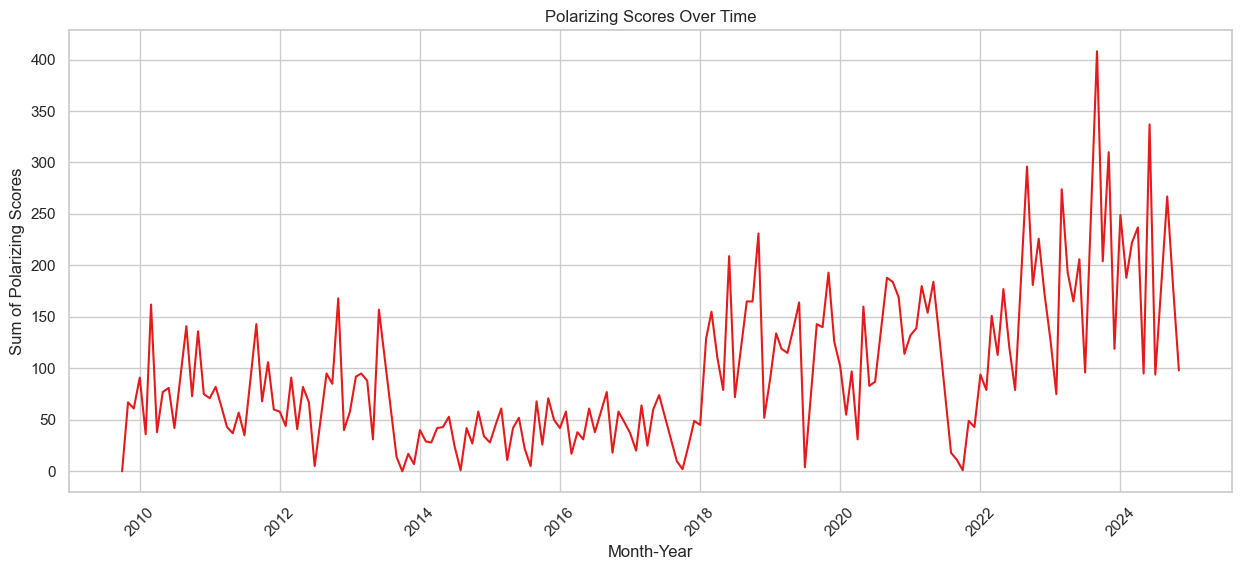

In [9]:
final_df['date'] = pd.to_datetime(final_df['date'])
final_df['month_year'] = final_df['date'].dt.to_period('M')

final_df['date'] = pd.to_datetime(final_df['date'])
final_df['week_year'] = final_df['date'].dt.to_period('W')

# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
monthly_grouped = final_df.groupby('month_year').agg({'polarizing': 'sum'})
monthly_grouped['polarizing']= monthly_grouped['polarizing'].astype('int')

# Reset index for plotting
monthly_grouped = monthly_grouped.reset_index()
monthly_grouped['month_year'] = monthly_grouped['month_year'].dt.to_timestamp()

sns.set(style='whitegrid')
sns.set_palette('Set1')
# Plotting using seaborn for a cleaner and prettier output
plt.figure(figsize=(15, 6))
sns.lineplot(x='month_year', y='polarizing', data=monthly_grouped)
plt.title('Polarizing Scores Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Sum of Polarizing Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
top_5_month = monthly_grouped.nlargest(5, 'polarizing')
top_5_month

,month_year,polarizing
153,2023-09-01,408
162,2024-06-01,337
155,2023-11-01,310
142,2022-09-01,296
148,2023-03-01,274


## 2.2. Weekly

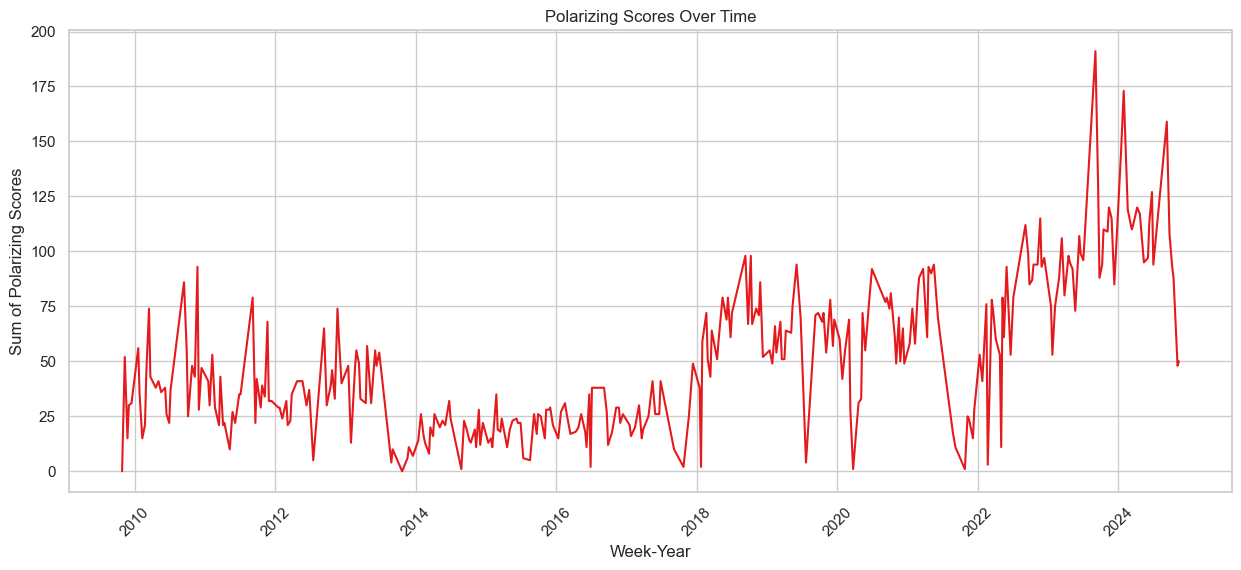

In [11]:
# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
weekly_grouped = final_df.groupby('week_year').agg({'polarizing': 'sum'})

# convert polarizing to int
weekly_grouped['polarizing']=weekly_grouped['polarizing'].astype('int')

# Reset index for plotting
weekly_grouped = weekly_grouped.reset_index()
weekly_grouped['week_year'] = weekly_grouped['week_year'].dt.to_timestamp()

# Plotting using seaborn for a cleaner and prettier output
plt.figure(figsize=(15, 6))
sns.lineplot(x='week_year', y='polarizing', data=weekly_grouped)
plt.title('Polarizing Scores Over Time')
plt.xlabel('Week-Year')
plt.ylabel('Sum of Polarizing Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [12]:
top_5_weeks = weekly_grouped.nlargest(5, 'polarizing')
top_5_weeks

,week_year,polarizing
292,2023-09-04,191
302,2024-01-29,173
313,2024-09-09,159
301,2024-01-15,145
293,2023-09-18,129


## 2.3 Daily

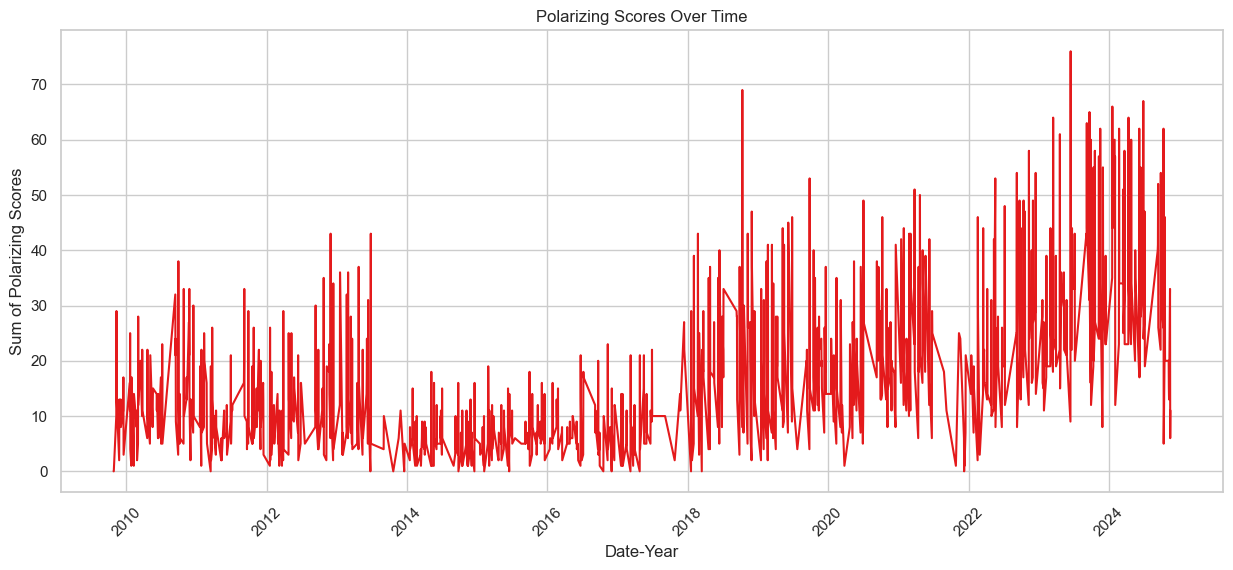

In [13]:
# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
daily_grouped = final_df.groupby('date').agg({'polarizing': 'sum'})
daily_grouped['polarizing']=daily_grouped['polarizing'].astype('int')

# Reset index for plotting
daily_grouped = daily_grouped.reset_index()

# Plotting using seaborn for a cleaner and prettier output
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='polarizing', data=daily_grouped)
plt.title('Polarizing Scores Over Time')
plt.xlabel('Date-Year')
plt.ylabel('Sum of Polarizing Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
top_5_days = daily_grouped.nlargest(5, 'polarizing')
top_5_days

,date,polarizing
842,2023-06-15,76
549,2018-10-11,69
911,2024-06-27,67
880,2024-01-18,66
855,2023-09-21,65


## 2.4 Rolling Average

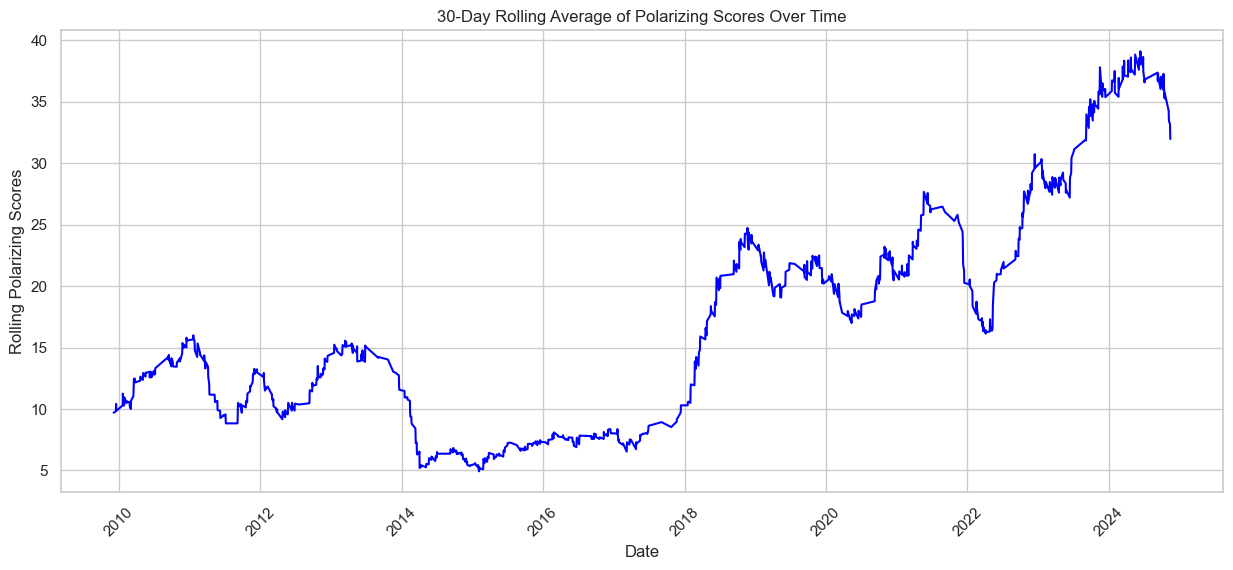

In [15]:
# Group by 'date', sum 'polarizing' and 'speech_length', and calculate frequency
daily_grouped = final_df.groupby('date').agg({'polarizing': 'sum'})

# Applying a 30-day rolling average for smoothing
daily_grouped['rolling_totals'] = daily_grouped['polarizing'].rolling(window=30, min_periods=10).mean()

# Resetting index for plotting
daily_grouped = daily_grouped.reset_index()

sns.set(style='whitegrid')
sns.set_palette('Set1')

# Plotting using seaborn for a cleaner and prettier output with rolling average
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_totals', data=daily_grouped, color='blue')
plt.title('30-Day Rolling Average of Polarizing Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3. Frequency Total Development

## 3.1 Monthly

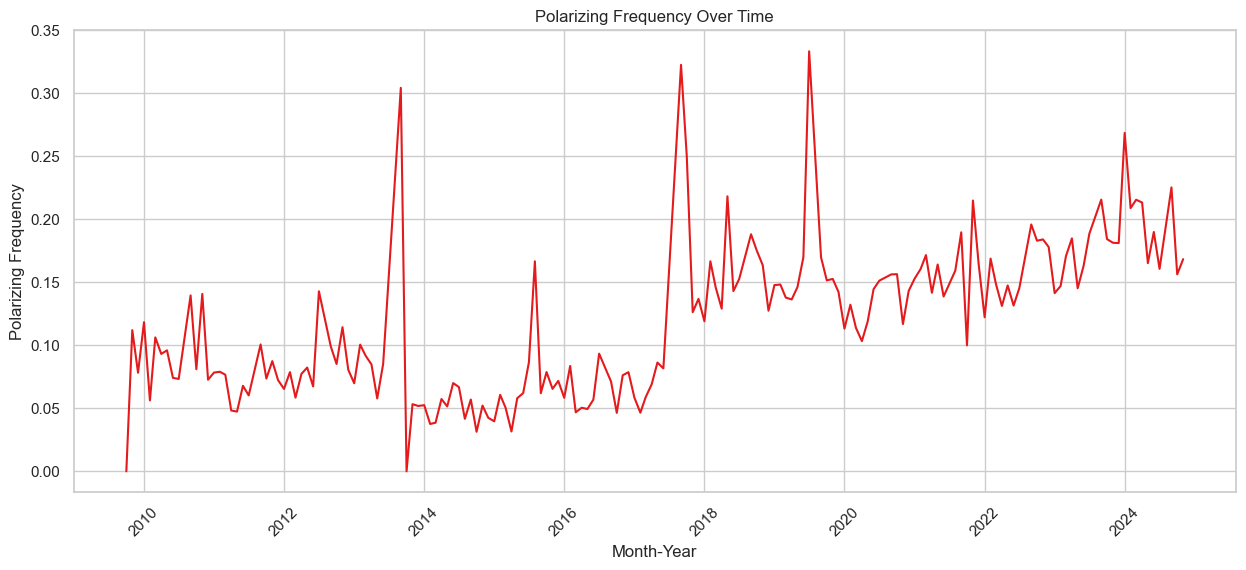

In [16]:
# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
monthly_grouped  = final_df.groupby('month_year').agg({'polarizing': 'sum', 'id': 'count'})
monthly_grouped['frequency'] = monthly_grouped['polarizing'] / monthly_grouped['id']
monthly_grouped['frequency'] = monthly_grouped['frequency'].astype('float')

# Reset index for plotting
monthly_grouped = monthly_grouped.reset_index()
monthly_grouped['month_year'] = monthly_grouped['month_year'].dt.to_timestamp()

# Plotting using seaborn for a cleaner and prettier output
plt.figure(figsize=(15, 6))
sns.lineplot(x='month_year', y='frequency', data=monthly_grouped)
plt.title('Polarizing Frequency Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Polarizing Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [17]:
top_5_month_frequency = monthly_grouped.nlargest(5, 'frequency')
top_5_month_frequency

,month_year,polarizing,id,frequency
108,2019-07-01,4,12,0.333333
87,2017-09-01,10,31,0.322581
42,2013-09-01,14,46,0.304348
157,2024-01-01,249,927,0.268608
88,2017-10-01,2,8,0.250000


## 3.2 Weekly Frequency

0.054025593654280585 0.1815472988506002
Increase from start to end of the timeframe: 236.04%


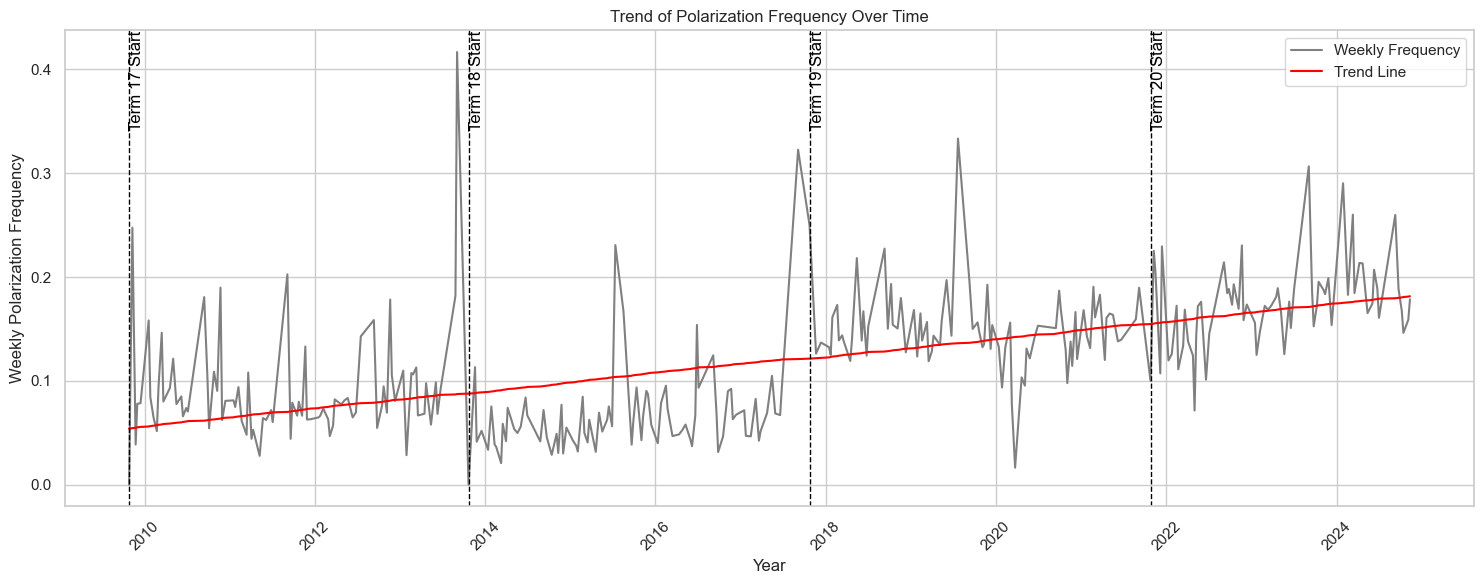

In [18]:
electoral_terms = {
    'Term 17 Start': '2009-10-27',
    'Term 18 Start': '2013-10-22',
    'Term 19 Start': '2017-10-24',
    'Term 20 Start': '2021-10-26'
}

# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
weekly_grouped = final_df.groupby('week_year').agg({'polarizing': 'sum', 'id': 'count'})
weekly_grouped['frequency'] = weekly_grouped['polarizing'] / weekly_grouped['id']
weekly_grouped['frequency'] =weekly_grouped['frequency'].astype('float')

# Reset index for plotting
weekly_grouped = weekly_grouped.reset_index()
weekly_grouped['week_year'] = weekly_grouped['week_year'].dt.to_timestamp()

# Convert 'week_year' to a timestamp at the beginning of the week for consistency
weekly_grouped['week_year'] = pd.to_datetime(weekly_grouped['week_year']).dt.to_period('W').dt.start_time

# Prepare data for trend line
X = np.array(range(len(weekly_grouped))).reshape(-1, 1)  # Numeric x-axis for trend line fitting
y = weekly_grouped['frequency'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
trend_line = model.predict(X)

# Calculating increase from start to end using the trend line
start_value = trend_line[0]  # First value in the trend line
end_value = trend_line[-1]  # Last value in the trend line
increase = (end_value - start_value) / start_value * 100  # Percentage increase

print(start_value, end_value)

print(f'Increase from start to end of the timeframe: {increase:.2f}%')

# Plotting
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='week_year', y='frequency', data=weekly_grouped, label='Weekly Frequency', color='grey')
plt.plot(weekly_grouped['week_year'], trend_line, label='Trend Line', color='red')

# Add vertical lines for each electoral term start
for term, start_date in electoral_terms.items():
    start_date = pd.to_datetime(start_date)
    ax.axvline(start_date, color='black', linestyle='--', lw=1)
    ax.text(start_date, ax.get_ylim()[1], term, rotation=90, ha='left', va='top', color='black', fontsize=12)


plt.title('Trend of Polarization Frequency Over Time')
plt.xlabel('Year')
plt.ylabel('Weekly Polarization Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('weekly_polarization_frequency_with linear regresssion.png')
plt.show()

In [19]:
top_5_weekly_frequency = weekly_grouped.nlargest(5, 'frequency')
top_5_weekly_frequency

,week_year,polarizing,id,frequency
83,2013-09-02,10,24,0.416667
205,2019-07-22,4,12,0.333333
167,2017-09-04,10,31,0.322581
292,2023-09-04,191,623,0.306581
302,2024-01-29,173,596,0.290268


## 3.3 Daily Frequency

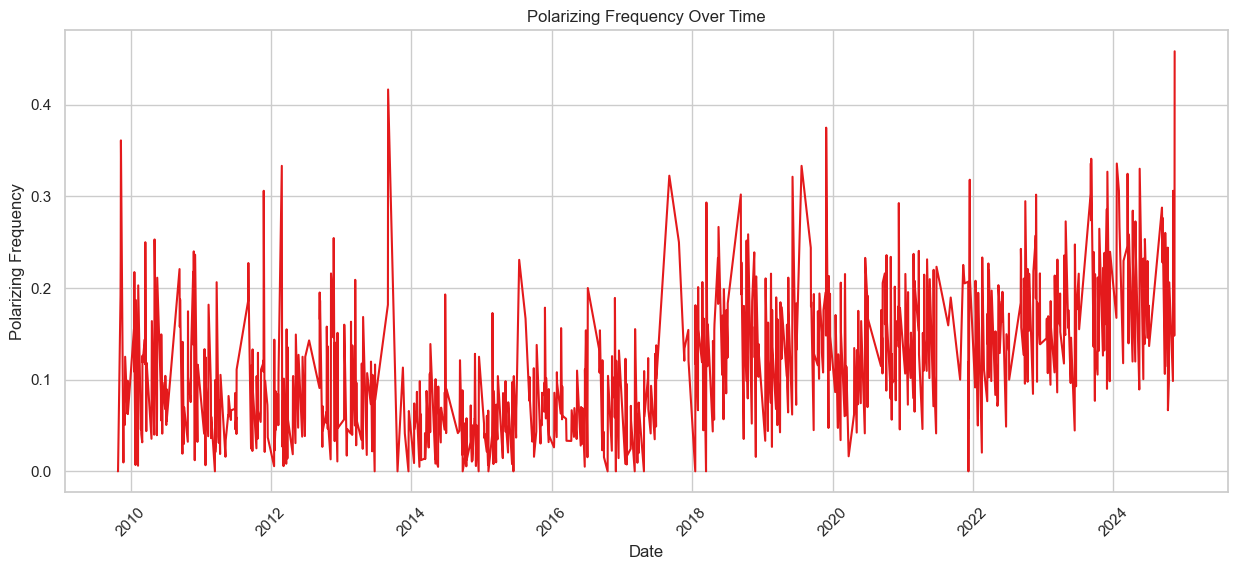

In [20]:
# Group by 'month_year', sum 'polarizing' and 'speech_length', and calculate frequency
daily_grouped = final_df.groupby('date').agg({'polarizing': 'sum', 'id': 'count'})
daily_grouped['frequency'] = daily_grouped['polarizing'] / daily_grouped['id']
daily_grouped['frequency'] =daily_grouped['frequency'].astype('float')

# Reset index for plotting
daily_grouped = daily_grouped.reset_index()

# Plotting using seaborn for a cleaner and prettier output
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='frequency', data=daily_grouped)
plt.title('Polarizing Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Polarizing Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [21]:
top_5_daily_frequency = daily_grouped.nlargest(5, 'frequency')
top_5_daily_frequency

,date,polarizing,id,frequency
934,2024-11-15,11,24,0.458333
250,2013-09-02,10,24,0.416667
626,2019-11-29,15,40,0.375000
4,2009-11-12,13,36,0.361111
853,2023-09-08,44,129,0.341085


## 3.4 Rolling Average

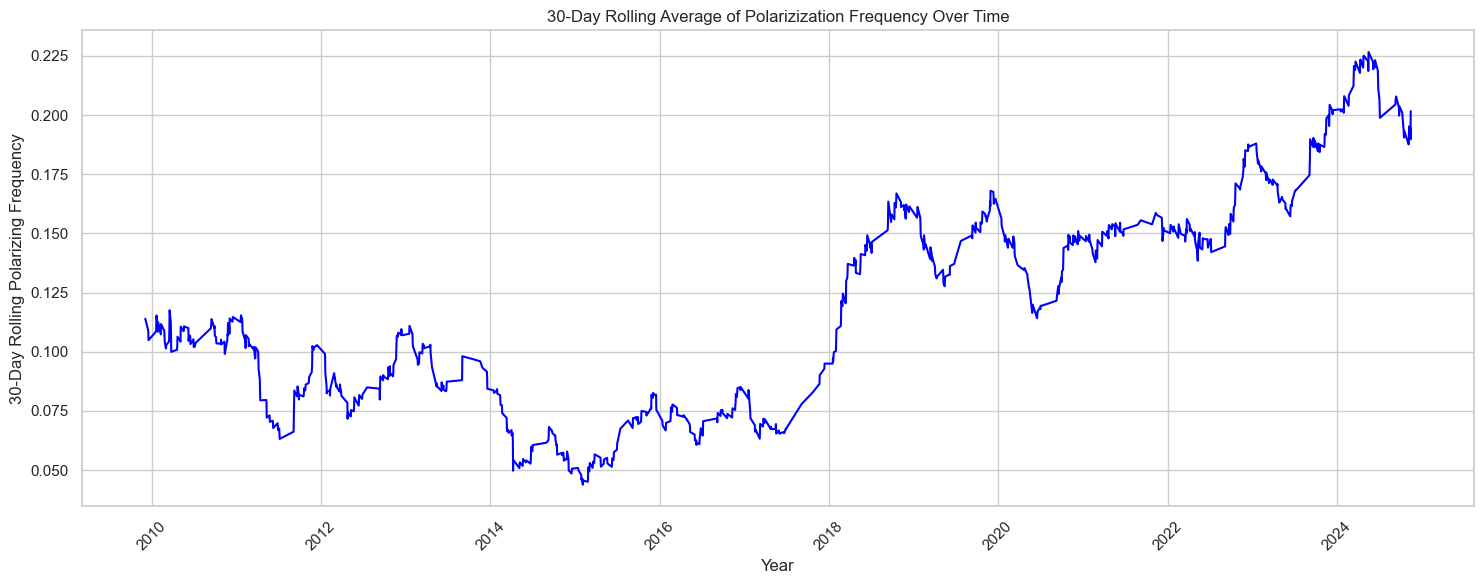

In [22]:
# Applying a 30-day rolling average for smoothing
daily_grouped['rolling_frequency_30'] = daily_grouped['frequency'].rolling(window=30, min_periods=10).mean()

# Resetting index for plotting
daily_grouped = daily_grouped.reset_index()

# Plotting using seaborn for a cleaner and prettier output with rolling average
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_frequency_30', data=daily_grouped, color='blue')
plt.title('30-Day Rolling Average of Polarizization Frequency Over Time', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.ylabel('30-Day Rolling Polarizing Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.savefig('total_rolling_frequency.png')
plt.show()

In [23]:
# Prepare data for trend line
X = np.array(range(len(monthly_grouped))).reshape(-1, 1)  # Numeric x-axis for trend line fitting
y = monthly_grouped['frequency'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)
trend_line = model.predict(X)

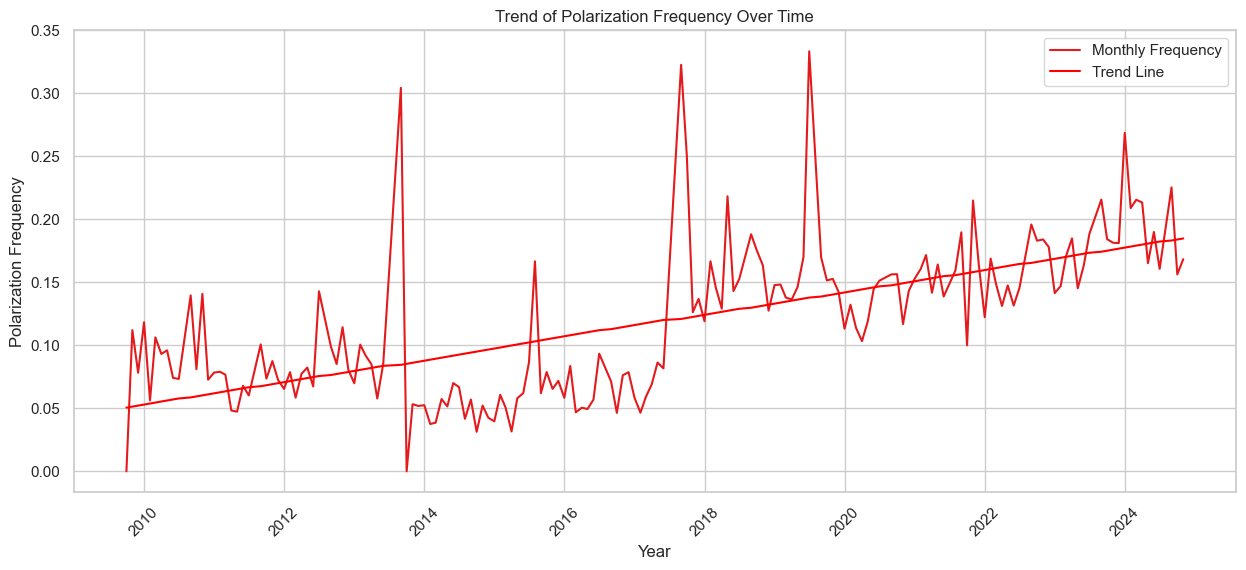

In [24]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='month_year', y='frequency', data=monthly_grouped, label='Monthly Frequency')
plt.plot(monthly_grouped['month_year'], trend_line, label='Trend Line', color='red')

plt.title('Trend of Polarization Frequency Over Time')
plt.xlabel('Year')
plt.ylabel('Polarization Frequency')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [25]:
# calculate the average frequency per electoral term
avg_freq_per_term = final_df.groupby(['electoral_term', 'date']).agg({'polarizing': 'sum', 'id': 'count'}).reset_index()

avg_freq_per_term['frequency'] = avg_freq_per_term['polarizing'] / avg_freq_per_term['id']

avg_freq_per_term = avg_freq_per_term.groupby('electoral_term').agg({'frequency': 'mean'}).reset_index()

avg_freq_per_term

,electoral_term,frequency
0,17,0.095535
1,18,0.065672
2,19,0.145737
3,20,0.182189


# Test for Frequency Comparison

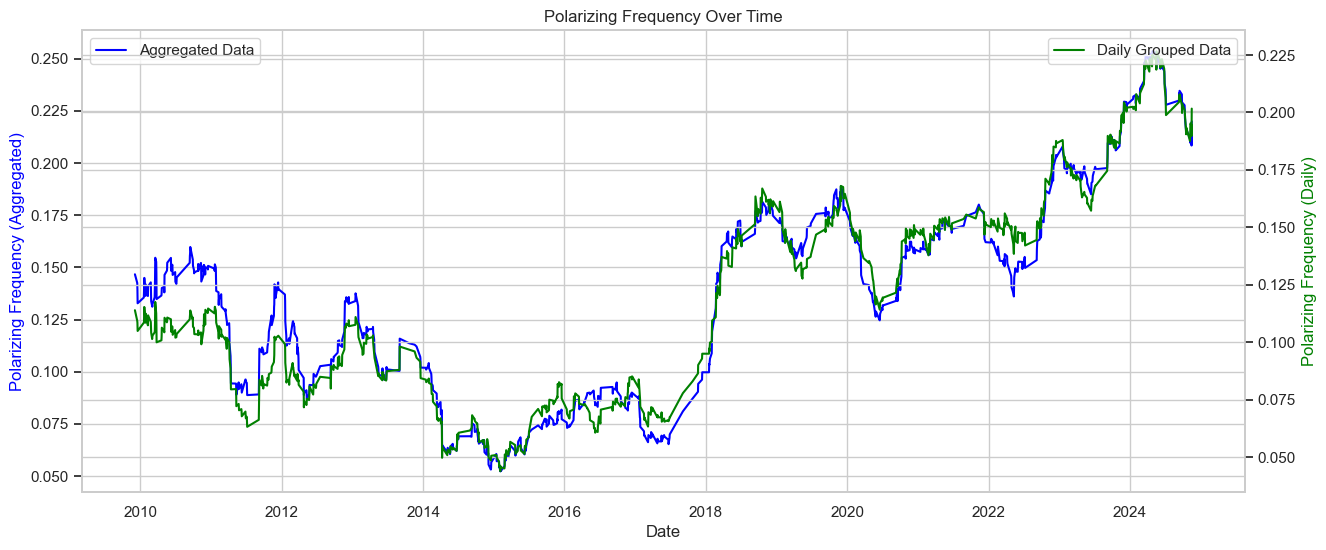

In [26]:

# Ensure your data is in the expected format, with polarizing marked as a binary column (1 or 0).
final_df['polarizing'] = final_df['polarizing'].astype(int)

# Group by 'date' and calculate the required sums.
aggregated_data = final_df.groupby('date').apply(
    lambda df: pd.Series({
        'total_speech_length': df['speech_length'].sum(),
        'polarizing_speech_length': df[df['polarizing'] == 1]['speech_length'].sum()
    })
).reset_index()

# Calculate the frequency as the proportion of polarizing speech length to total speech length.
aggregated_data['polarizing_frequency'] = aggregated_data['polarizing_speech_length'] / aggregated_data['total_speech_length']

# Convert the frequency to a float for consistency.
aggregated_data['polarizing_frequency'] = aggregated_data['polarizing_frequency'].astype(float)

aggregated_data['rolling_frequency_30'] = aggregated_data['polarizing_frequency'].rolling(window=30, min_periods=10).mean()


plt.figure(figsize=(15, 6))

# Create the first Axes
ax1 = plt.gca()  # Get the current axis
sns.lineplot(x='date', y='rolling_frequency_30', data=aggregated_data, ax=ax1, color='blue', label='Aggregated Data')

# Create a second Axes that shares the same x-axis
ax2 = ax1.twinx()
sns.lineplot(x='date', y='rolling_frequency_30', data=daily_grouped, ax=ax2, color='green', label='Daily Grouped Data')

# Setting labels for both y-axes
ax1.set_ylabel('Polarizing Frequency (Aggregated)', color='blue')
ax2.set_ylabel('Polarizing Frequency (Daily)', color='green')

# Setting the title and x-axis label
plt.title('Polarizing Frequency Over Time')
ax1.set_xlabel('Date')
plt.xticks(rotation=45)

# Optional: add a grid
ax1.grid(True)

# Show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()


# 4. Extreme Events

## 4.1 Europe

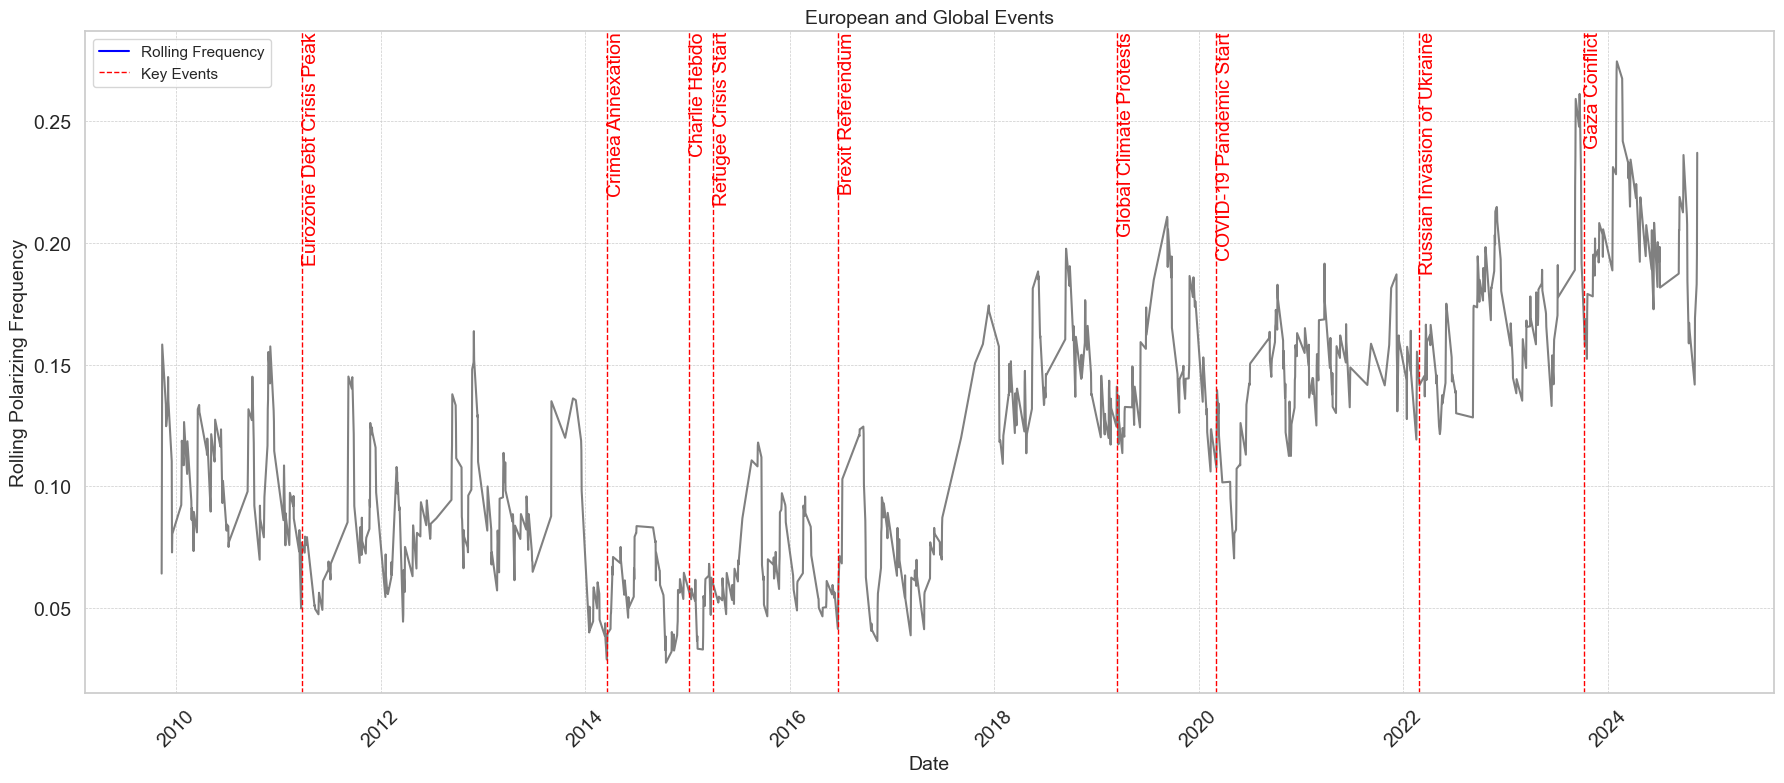

In [25]:
# Calculate the 7-day rolling average
daily_grouped['rolling_frequency_7'] = daily_grouped['frequency'].rolling(window=7, min_periods=3).mean()

# Key event dates
events = {
    'Eurozone Debt Crisis Peak': '2011-03-25',
    'Crimea Annexation': '2014-03-18',
    'Refugee Crisis Start': '2015-04-01',
    'Global Climate Protests': '2019-03-15',
    'COVID-19 Pandemic Start': '2020-03-01',
    'Gaza Conflict': '2023-10-07',
    'Brexit Referendum': '2016-06-23',
    'Russian Invasion of Ukraine':'2022-02-24',
    'Charlie Hebdo': '2015-01-07',
}

# Plotting
sns.set_style('whitegrid')  # Set the style for better aesthetics
sns.set_palette('Set1')
  # Set the color palette for better legibility
plt.figure(figsize=(18, 8))  # Increased figure size for better legibility
ax = sns.lineplot(x='date', y='rolling_frequency_7', data=daily_grouped, linewidth=1.5, color='grey')

# Add vertical lines and labels for key events
for event, date in events.items():
    event_date = pd.to_datetime(date)
    ax.axvline(event_date, color='red', linestyle='--', lw=1)
    plt.text(event_date, ax.get_ylim()[1], event, rotation=90, ha='left', va='top', color='red', fontsize=14)

# Improve plot aesthetics
plt.title('European and Global Events', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Rolling Polarizing Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)

# Adding a legend for clarity
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=1.5, label='Rolling Frequency'),
                   Line2D([0], [0], color='red', linestyle='--', lw=1, label='Key Events')]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()  # Adjusts plot parameters for better fit
plt.savefig('rolling_frequency_with_events.png')

plt.show()

In [26]:
# List of durations in months to test
durations = [ 1, 3, 6]

# Initialize a DataFrame to store results
results = []

# Loop over each event and each duration
for event, date_str in events.items():
    event_date = pd.to_datetime(date_str)
    
    for duration in durations:
        pre_event_start = event_date - pd.DateOffset(months=duration)
        post_event_end = event_date + pd.DateOffset(months=duration)

        # Filter data for the period before and after the event
        pre_event_data = daily_grouped[(daily_grouped['date'] >= pre_event_start) & (daily_grouped['date'] < event_date)]
        post_event_data = daily_grouped[(daily_grouped['date'] > event_date) & (daily_grouped['date'] <= post_event_end)]

        # Calculate average frequency
        pre_avg = pre_event_data['frequency'].mean()
        post_avg = post_event_data['frequency'].mean()

        # Calculate the percentage change
        change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else None

        # Store the results
        results.append({
            'Event': event,
            'Period (months)': duration,
            'Pre-Event Average': pre_avg,
            'Post-Event Average': post_avg,
            'Change': change
        })


durations_2 = [ 1, 2]

# Initialize a DataFrame to store results
results_2 = []

# Loop over each event and each duration
for event, date_str in events.items():
    event_date = pd.to_datetime(date_str)
    
    for duration in durations_2:
        pre_event_start = event_date - pd.DateOffset(weeks=duration)
        post_event_end = event_date + pd.DateOffset(weeks=duration)

        # Filter data for the period before and after the event
        pre_event_data = daily_grouped[(daily_grouped['date'] >= pre_event_start) & (daily_grouped['date'] < event_date)]
        post_event_data = daily_grouped[(daily_grouped['date'] > event_date) & (daily_grouped['date'] <= post_event_end)]

        # Calculate average frequency
        pre_avg = pre_event_data['frequency'].mean()
        post_avg = post_event_data['frequency'].mean()

        # Calculate the percentage change
        change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else None

        # Store the results
        results.append({
            'Event': event,
            'Period (weeks)': duration,
            'Pre-Event Average': pre_avg,
            'Post-Event Average': post_avg,
            'Change': change
        })



# Convert the list of results to a DataFrame for easier handling and visualization
results_df = pd.DataFrame(results)
results_2_df = pd.DataFrame(results_2)
results_df = results_df.append(results_2_df)


# if duration month is na, divide duration weeks by four and inpute
results_df['Period (months)'] = results_df['Period (months)'].fillna(results_df['Period (weeks)']/4)
results_df = results_df.drop(columns=['Period (weeks)'])
results_df = results_df.sort_values(by=['Event','Period (months)'], ascending=False)

# export results to excel
results_df.to_excel('polarization_frequency_change.xlsx', index=False)
results_df

,Event,Period (months),Pre-Event Average,Post-Event Average,Change
23,Russian Invasion of Ukraine,6.00,0.153320,0.142080,-7.331414
22,Russian Invasion of Ukraine,3.00,0.145807,0.141821,-2.733413
21,Russian Invasion of Ukraine,1.00,0.146523,0.143617,-1.983443
42,Russian Invasion of Ukraine,0.50,0.153340,0.111111,-27.539307
41,Russian Invasion of Ukraine,0.25,0.219806,0.111111,-49.450300
8,Refugee Crisis Start,6.00,0.050294,0.069435,38.058733
7,Refugee Crisis Start,3.00,0.052555,0.057358,9.138903
6,Refugee Crisis Start,1.00,0.056420,0.038501,-31.760531
32,Refugee Crisis Start,0.50,0.058248,NaN,NaN
31,Refugee Crisis Start,0.25,0.070951,NaN,NaN


## 4.2 Germany

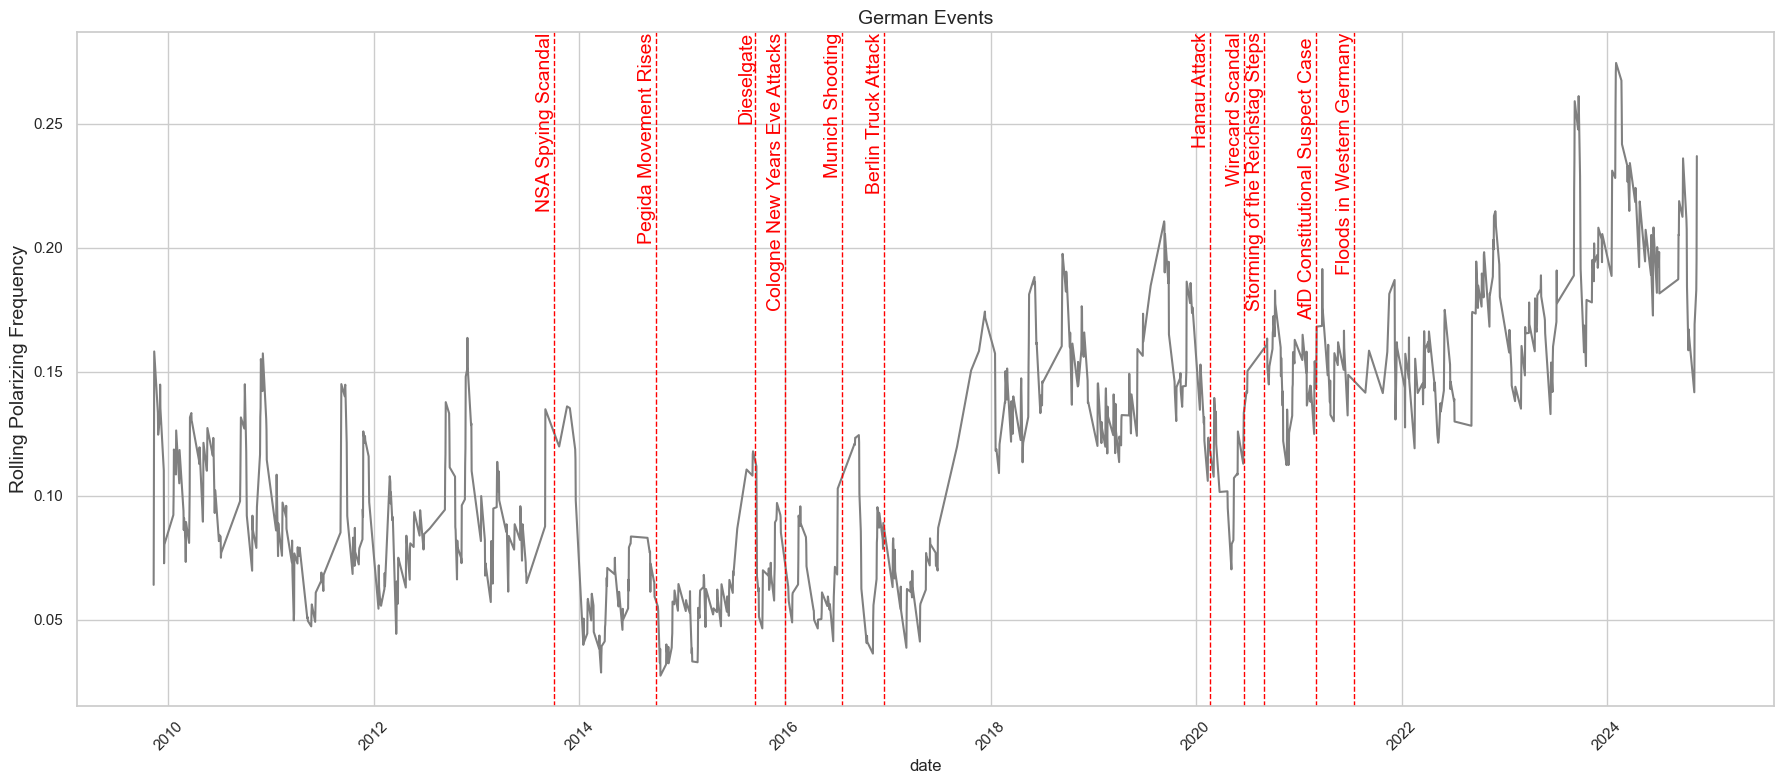

In [27]:
german_events = {
    'Berlin Truck Attack': '2016-12-19',
    'Hanau Attack': '2020-02-19',
    'Munich Shooting': '2016-07-22',
    'Cologne New Years Eve Attacks': '2015-12-31',
    'Floods in Western Germany': '2021-07-14',
    'Wirecard Scandal': '2020-06-18',
    'Dieselgate': '2015-09-18',
    'NSA Spying Scandal': '2013-10-01',
    'Pegida Movement Rises': '2014-10-01',
    'Storming of the Reichstag Steps': '2020-08-29',
    'AfD Constitutional Suspect Case ': '2021-03-03',
}


# Plotting
plt.figure(figsize=(18, 8))
ax = sns.lineplot(x='date', y='rolling_frequency_7', data=daily_grouped, color='grey', linewidth=1.5)

# Add vertical lines for key events and German specific events
for event, date in german_events.items():
    date = pd.to_datetime(date)
    ax.axvline(date, color='red', linestyle='--', lw=1)
    plt.text(date, ax.get_ylim()[1], event, rotation=90, ha='right', va='top', color='red', fontsize=14)

# Plot adjustments
plt.title('German Events', fontsize=14)
plt.ylabel('Rolling Polarizing Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()  # Adjust subplots to give some padding and prevent overlap
plt.savefig('rolling_frequency_with_german_events.png')
plt.show()

In [28]:
# List of durations in months to test
durations = [ 1, 3, 6]

# Initialize a DataFrame to store results
results = []

# Loop over each event and each duration
for event, date_str in german_events.items():
    event_date = pd.to_datetime(date_str)
    
    for duration in durations:
        pre_event_start = event_date - pd.DateOffset(months=duration)
        post_event_end = event_date + pd.DateOffset(months=duration)

        # Filter data for the period before and after the event
        pre_event_data = daily_grouped[(daily_grouped['date'] >= pre_event_start) & (daily_grouped['date'] < event_date)]
        post_event_data = daily_grouped[(daily_grouped['date'] > event_date) & (daily_grouped['date'] <= post_event_end)]

        # Calculate average frequency
        pre_avg = pre_event_data['frequency'].mean()
        post_avg = post_event_data['frequency'].mean()

        # Calculate the percentage change
        change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else None

        # Store the results
        results.append({
            'Event': event,
            'Period (months)': duration,
            'Pre-Event Average': pre_avg,
            'Post-Event Average': post_avg,
            'Change': change
        })


durations_2 = [ 1, 2]

# Initialize a DataFrame to store results
results_2 = []

# Loop over each event and each duration
for event, date_str in german_events.items():
    event_date = pd.to_datetime(date_str)
    
    for duration in durations_2:
        pre_event_start = event_date - pd.DateOffset(weeks=duration)
        post_event_end = event_date + pd.DateOffset(weeks=duration)

        # Filter data for the period before and after the event
        pre_event_data = daily_grouped[(daily_grouped['date'] >= pre_event_start) & (daily_grouped['date'] < event_date)]
        post_event_data = daily_grouped[(daily_grouped['date'] > event_date) & (daily_grouped['date'] <= post_event_end)]

        # Calculate average frequency
        pre_avg = pre_event_data['frequency'].mean()
        post_avg = post_event_data['frequency'].mean()

        # Calculate the percentage change
        change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else None

        # Store the results
        results.append({
            'Event': event,
            'Period (weeks)': duration,
            'Pre-Event Average': pre_avg,
            'Post-Event Average': post_avg,
            'Change': change
        })



# Convert the list of results to a DataFrame for easier handling and visualization
results_df = pd.DataFrame(results)
results_2_df = pd.DataFrame(results_2)
results_df = results_df.append(results_2_df)


# if duration month is na, divide duration weeks by four and inpute
results_df['Period (months)'] = results_df['Period (months)'].fillna(results_df['Period (weeks)']/4)
results_df = results_df.drop(columns=['Period (weeks)'])
results_df = results_df.sort_values(by=['Event','Period (months)'], ascending=False)

results_df.to_excel('polarization_frequency_change_german_events.xlsx', index=False)
results_df

,Event,Period (months),Pre-Event Average,Post-Event Average,Change
17,Wirecard Scandal,6.00,0.114137,0.151095,32.380419
16,Wirecard Scandal,3.00,0.098192,0.159280,62.212480
15,Wirecard Scandal,1.00,0.102887,0.170664,65.875784
44,Wirecard Scandal,0.50,0.041420,0.171664,314.444946
43,Wirecard Scandal,0.25,0.041420,0.232877,462.230920
29,Storming of the Reichstag Steps,6.00,0.120207,0.148961,23.920532
28,Storming of the Reichstag Steps,3.00,0.152184,0.144378,-5.129705
27,Storming of the Reichstag Steps,1.00,NaN,0.159238,NaN
52,Storming of the Reichstag Steps,0.50,NaN,0.147159,NaN
51,Storming of the Reichstag Steps,0.25,NaN,NaN,NaN


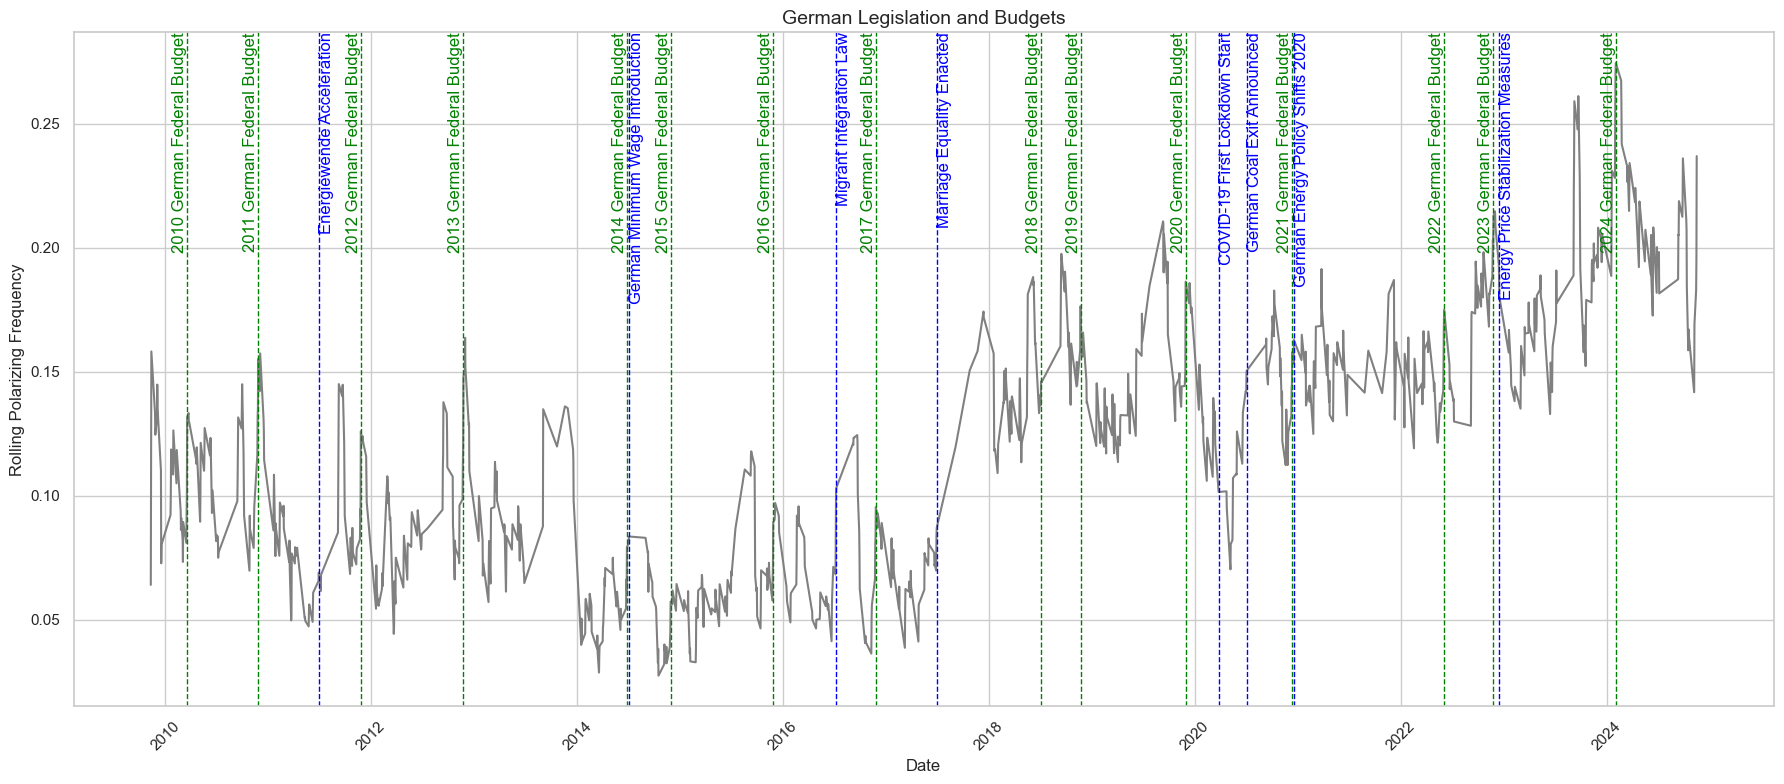

In [29]:
# General legislation
german_legislation = {
    'Migrant Integration Law': '2016-07-07',
    'Marriage Equality Enacted': '2017-06-30',
    'German Coal Exit Announced': '2020-07-03', #checken
    'COVID-19 First Lockdown Start': '2020-03-25',
    'German Energy Policy Shifts 2020': '2020-12-17',
    'Energiewende Acceleration': '2011-06-30',
    'Energy Price Stabilization Measures': '2022-12-15',
    'German Minimum Wage Introduction': '2014-07-03',
}

#out:     'Cannabis Legalization Announced': '2022-11-01',

# Budget-related laws
german_budgets = {
    '2022 German Federal Budget': '2022-06-03',
    '2021 German Federal Budget': '2020-12-11',
    '2020 German Federal Budget': '2019-11-29',
    '2019 German Federal Budget': '2018-11-23',
    '2018 German Federal Budget': '2018-07-05', 
    '2017 German Federal Budget': '2016-11-25', 
    '2023 German Federal Budget': '2022-11-25',
    '2024 German Federal Budget': '2024-02-02',
    '2016 German Federal Budget': '2015-11-27',
    '2015 German Federal Budget': '2014-11-28',
    '2014 German Federal Budget': '2014-06-27',
    '2013 German Federal Budget': '2012-11-23',
    '2012 German Federal Budget': '2011-11-25',
    '2011 German Federal Budget': '2010-11-26',
    '2010 German Federal Budget': '2010-03-19',
}

# Plotting
plt.figure(figsize=(18, 8))
ax = sns.lineplot(x='date', y='rolling_frequency_7', data=daily_grouped, color='grey', linewidth=1.5)

# Add vertical lines for general legislations
for event, date in german_legislation.items():
    date = pd.to_datetime(date)
    ax.axvline(date, color='blue', linestyle='--', lw=1)
    plt.text(date, ax.get_ylim()[1], event, rotation=90, ha='left', va='top', color='blue', fontsize=12)

# Add vertical lines for budget laws
for event, date in german_budgets.items():
    date = pd.to_datetime(date)
    ax.axvline(date, color='green', linestyle='--', lw=1)
    plt.text(date, ax.get_ylim()[1], event, rotation=90, ha='right', va='top', color='green', fontsize=12)

# Plot adjustments
plt.title('German Legislation and Budgets', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rolling Polarizing Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()  # Adjust subplots to give some padding and prevent overlap
plt.savefig('rolling_frequency_with_german_legislation_and_budgets.png')
plt.show()


In [30]:
german_legislation.update(german_budgets)

# List of durations in months to test
durations = [ 1, 3, 6]

# Initialize a DataFrame to store results
results = []

# Loop over each event and each duration
for event, date_str in german_legislation.items():
    event_date = pd.to_datetime(date_str)
    
    for duration in durations:
        pre_event_start = event_date - pd.DateOffset(months=duration)
        post_event_end = event_date + pd.DateOffset(months=duration)

        # Filter data for the period before and after the event
        pre_event_data = daily_grouped[(daily_grouped['date'] >= pre_event_start) & (daily_grouped['date'] <= event_date)]
        post_event_data = daily_grouped[(daily_grouped['date'] > event_date) & (daily_grouped['date'] <= post_event_end)]

        # Calculate average frequency
        pre_avg = pre_event_data['frequency'].mean()
        post_avg = post_event_data['frequency'].mean()

        # Calculate the percentage change
        change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else None

        # Store the results
        results.append({
            'Event': event,
            'Period (months)': duration,
            'Pre-Event Average': pre_avg,
            'Post-Event Average': post_avg,
            'Change': change
        })


durations_2 = [ 1, 2]

# Initialize a DataFrame to store results
results_2 = []

# Loop over each event and each duration
for event, date_str in german_legislation.items():
    event_date = pd.to_datetime(date_str)
    
    for duration in durations_2:
        pre_event_start = event_date - pd.DateOffset(weeks=duration)
        post_event_end = event_date + pd.DateOffset(weeks=duration)

        # Filter data for the period before and after the event
        pre_event_data = daily_grouped[(daily_grouped['date'] >= pre_event_start) & (daily_grouped['date'] < event_date)]
        post_event_data = daily_grouped[(daily_grouped['date'] > event_date) & (daily_grouped['date'] <= post_event_end)]

        # Calculate average frequency
        pre_avg = pre_event_data['frequency'].mean()
        post_avg = post_event_data['frequency'].mean()

        # Calculate the percentage change
        change = ((post_avg - pre_avg) / pre_avg) * 100 if pre_avg != 0 else None

        # Store the results
        results.append({
            'Event': event,
            'Period (weeks)': duration,
            'Pre-Event Average': pre_avg,
            'Post-Event Average': post_avg,
            'Change': change
        })



# Convert the list of results to a DataFrame for easier handling and visualization
results_df = pd.DataFrame(results)
results_2_df = pd.DataFrame(results_2)
results_df = results_df.append(results_2_df)


# if duration month is na, divide duration weeks by four and inpute
results_df['Period (months)'] = results_df['Period (months)'].fillna(results_df['Period (weeks)']/4)
results_df = results_df.drop(columns=['Period (weeks)'])

results_df = results_df.sort_values(by=['Event','Period (months)'], ascending=False)

results_df.to_excel('polarization_frequency_change_german_policies.xlsx', index=False)
# show all 
pd.set_option('display.max_rows', None)
results_df

,Event,Period (months),Pre-Event Average,Post-Event Average,Change
2,Migrant Integration Law,6.00,0.069419,0.078499,13.079628
1,Migrant Integration Law,3.00,0.069122,0.079087,14.416449
0,Migrant Integration Law,1.00,0.085673,NaN,NaN
70,Migrant Integration Law,0.50,0.101122,NaN,NaN
69,Migrant Integration Law,0.25,0.078558,NaN,NaN
5,Marriage Equality Enacted,6.00,0.068321,0.183653,168.810088
4,Marriage Equality Enacted,3.00,0.078675,0.322581,310.016788
3,Marriage Equality Enacted,1.00,0.080847,NaN,NaN
72,Marriage Equality Enacted,0.50,0.086077,NaN,NaN
71,Marriage Equality Enacted,0.25,0.095808,NaN,NaN


In [31]:
# for the federal budgets can you calculate the average channge for each epriod?
# Filter results_df for Budget
budget_results = results_df[results_df['Event'].str.contains('Budget')]
budget_results = budget_results.groupby('Period (months)').agg({'Change': 'mean'}).reset_index()
budget_results

,Period (months),Change
0,0.25,-30.122426
1,0.50,-27.637977
2,1.00,-23.377450
3,3.00,-13.917669
4,6.00,-10.679995


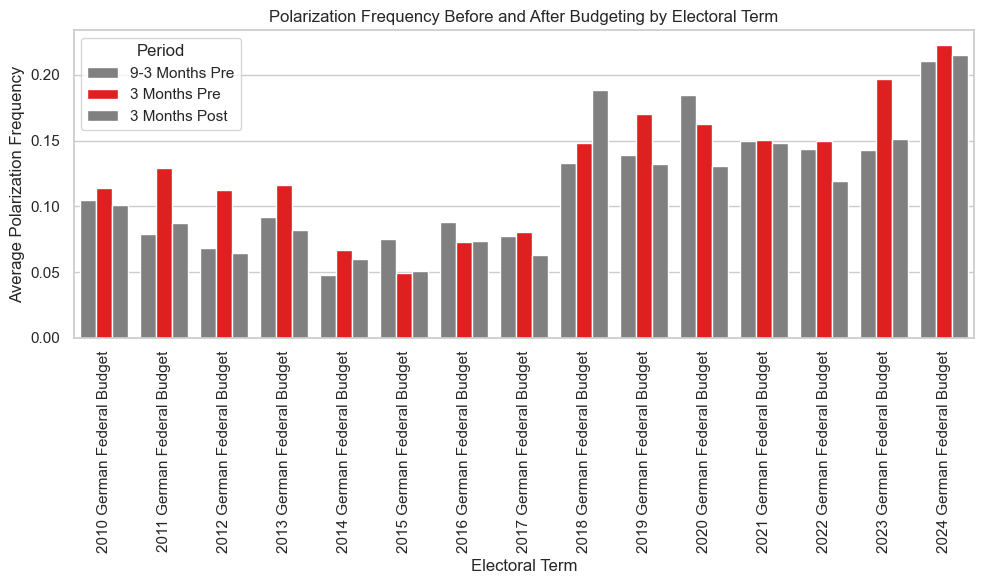

In [32]:

sorted_german_budgets = dict(sorted(german_budgets.items()))

# Convert dates in german_budgets to datetime
for key, value in sorted_german_budgets.items():
    sorted_german_budgets[key] = pd.to_datetime(value)

# Data preparation for plotting
results = []
for name, date in sorted_german_budgets.items():
    # Define periods
    pre_event_3m = (date - pd.DateOffset(months=3), date)
    pre_event_9m = (date - pd.DateOffset(months=6), date - pd.DateOffset(months=3))
    post_event_3m = (date, date + pd.DateOffset(months=3))
    
    # Calculate average frequency for each period
    for period, label in zip([pre_event_9m, pre_event_3m, post_event_3m], ['9-3 Months Pre', '3 Months Pre', '3 Months Post']):
        period_data = daily_grouped[(daily_grouped['date'] > period[0]) & (daily_grouped['date'] <= period[1])]
        avg_freq = period_data['frequency'].mean()
        results.append({
            'Event': name,
            'Period': label,
            'Average Frequency': avg_freq
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)



# Define colors for highlighting
color_palette = {'9-3 Months Pre': 'grey', '3 Months Pre': 'red', '3 Months Post': 'grey'}

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.barplot(x='Event', y='Average Frequency', hue='Period', data=results_df, palette=color_palette)

# Customizing the plot
plt.title('Polarization Frequency Before and After Budgeting by Electoral Term')
plt.xlabel('Electoral Term')
plt.ylabel('Average Polarization Frequency')
plt.xticks(rotation=90)
plt.legend(title='Period')
plt.tight_layout()

plt.savefig('polarization_frequency_before_after_budgeting.png')

# Show the plot
plt.show()

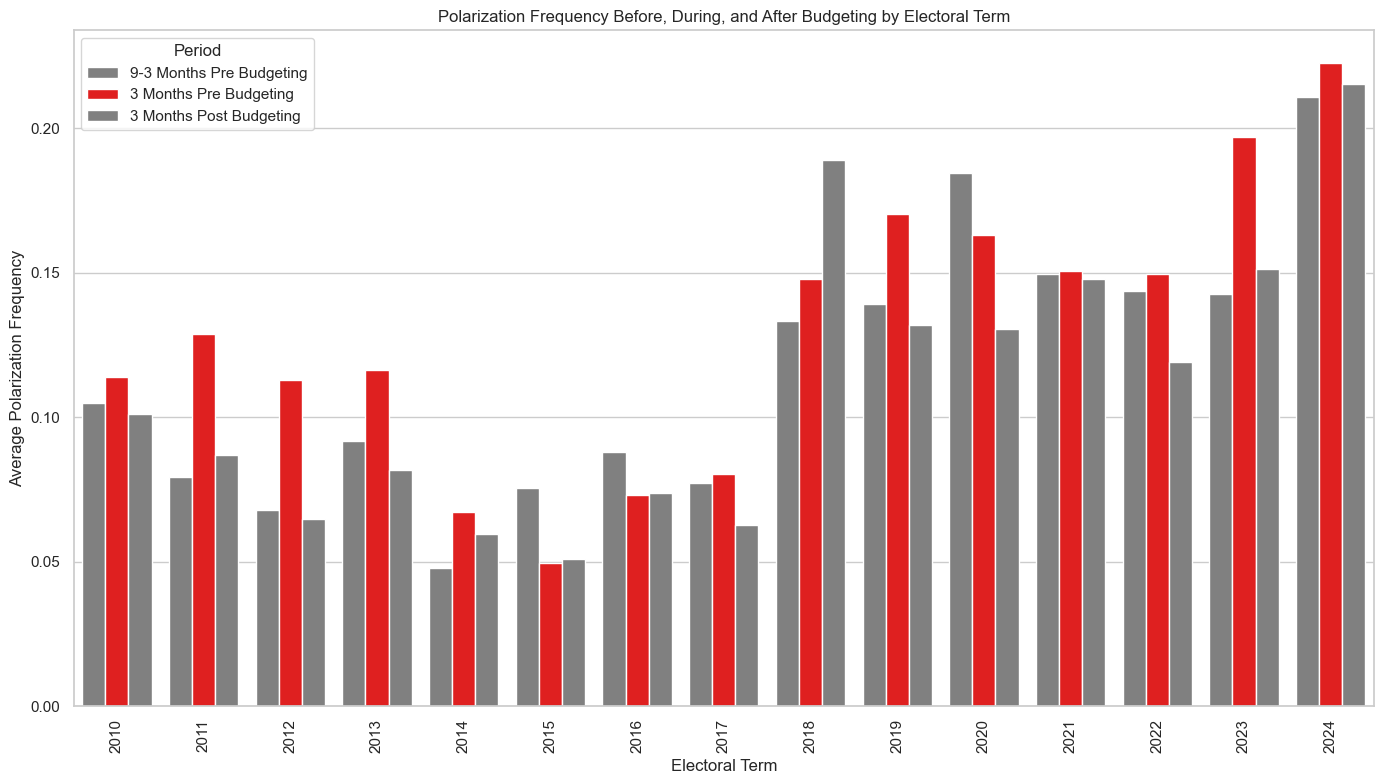

In [33]:
sorted_german_budgets = dict(sorted(german_budgets.items()))

# Convert dates in german_budgets to datetime
for key, value in sorted_german_budgets.items():
    sorted_german_budgets[key] = pd.to_datetime(value)

# Data preparation for plotting
results = []
for name, date in sorted_german_budgets.items():
    # Extract the year from the budget's name for labeling purposes
    year_label = name.split()[0]  # Assuming each key is like '2010 German Federal Budget'
    
    # Define periods
    pre_event_3m = (date - pd.DateOffset(months=3), date)
    pre_event_9m = (date - pd.DateOffset(months=6), date - pd.DateOffset(months=3))
    post_event_3m = (date, date + pd.DateOffset(months=3))
    
    # Calculate average frequency for each period
    for period, label in zip([pre_event_9m, pre_event_3m, post_event_3m], ['9-3 Months Pre Budgeting', '3 Months Pre Budgeting', '3 Months Post Budgeting']):
        period_data = daily_grouped[(daily_grouped['date'] > period[0]) & (daily_grouped['date'] <= period[1])]
        avg_freq = period_data['frequency'].mean()
        results.append({
            'Event': year_label,
            'Period': label,
            'Average Frequency': avg_freq
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Define colors for highlighting
color_palette = {'9-3 Months Pre Budgeting': 'grey', '3 Months Pre Budgeting': 'red', '3 Months Post Budgeting': 'grey'}

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.set_style('whitegrid')
ax = sns.barplot(x='Event', y='Average Frequency', hue='Period', data=results_df, palette=color_palette)

# Customizing the plot
plt.title('Polarization Frequency Before, During, and After Budgeting by Electoral Term')
plt.xlabel('Electoral Term')
plt.ylabel('Average Polarization Frequency')
plt.xticks(rotation=90)
plt.legend(title='Period')
plt.tight_layout()

plt.savefig('polarization_frequency_before_after_budgeting.png')
plt.show()


In [34]:
sorted_german_budgets = {k: pd.to_datetime(v) for k, v in german_budgets.items()}

# Filter daily_grouped DataFrame for dates that match the budget dates
budget_dates = daily_grouped[daily_grouped['date'].isin(sorted_german_budgets.values())]

budget_dates['year'] = budget_dates['date'].dt.year


#calculate average frequency for each calendar year
daily_grouped['year'] = daily_grouped['date'].dt.year

# Group by 'year' and calculate the average frequency
yearly_grouped = daily_grouped.groupby('year').agg({'frequency': 'mean'}).reset_index()

# merge frequency for budget dates with yearly_grouped
budget_dates = budget_dates.merge(yearly_grouped[['year', 'frequency']], on='year', suffixes=('', '_yearly'))

budget_dates['deviation_from_yearly_average']= budget_dates['frequency']/budget_dates['frequency_yearly']-1


print(budget_dates.deviation_from_yearly_average.mean())
budget_dates

budget_dates

1.1281858076246245


,index,date,polarizing,id,frequency,rolling_frequency_30,rolling_frequency_7,year,frequency_yearly,deviation_from_yearly_average
0,31,2010-03-19,16,64,0.250000,0.117506,0.131654,2010,0.110116,1.270337
1,74,2010-11-26,12,50,0.240000,0.112124,0.155148,2010,0.110116,1.179523
2,142,2011-11-25,15,49,0.306122,0.102344,0.125991,2011,0.083501,2.666092
3,206,2012-11-23,14,55,0.254545,0.106751,0.148086,2012,0.091847,1.771393
4,321,2014-11-28,5,39,0.128205,0.057774,0.057367,2014,0.055196,1.322729
5,391,2015-11-27,5,28,0.178571,0.081799,0.089296,2015,0.066400,1.689346
6,454,2016-11-25,7,37,0.189189,0.082116,0.095428,2016,0.073167,1.585731
7,540,2018-07-05,33,180,0.183333,0.146389,0.145593,2018,0.149289,0.228046
8,560,2018-11-23,6,38,0.157895,0.161367,0.161251,2018,0.149289,0.057647
9,626,2019-11-29,15,40,0.375000,0.168009,0.186383,2019,0.149201,1.513381


## 4.4 Most significant changes

Daily

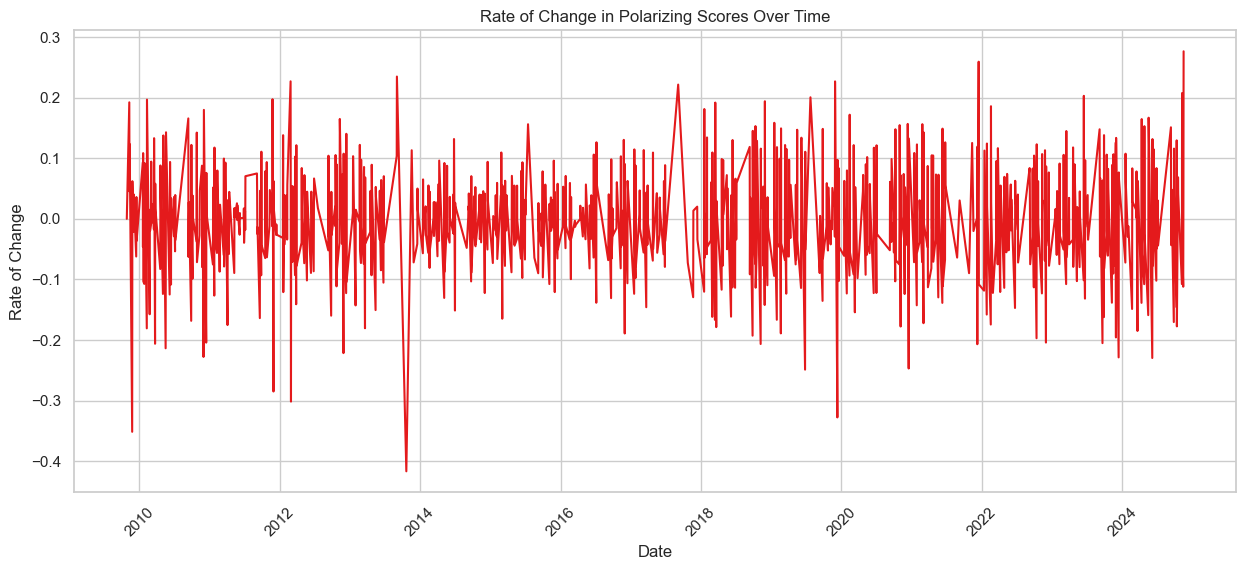

Top 10 Rises in Polarizing Scores:
          date  rate_of_change
934 2024-11-15        0.276515
741 2021-12-15        0.259358
250 2013-09-02        0.234848
158 2012-02-27        0.226950
626 2019-11-29        0.226852
494 2017-09-04        0.221571
930 2024-11-07        0.207600
842 2023-06-15        0.203003
603 2019-07-24        0.200590
142 2011-11-25        0.197427

Bottom 10 Falls in Polarizing Scores:
          date  rate_of_change
876 2023-12-13       -0.228632
904 2024-06-05       -0.229630
695 2020-12-16       -0.246969
600 2019-06-26       -0.248848
143 2011-11-30       -0.284958
159 2012-02-29       -0.301587
627 2019-12-11       -0.327703
5   2009-11-25       -0.351449
251 2013-10-21       -0.416667
0   2009-10-27             NaN


In [35]:
# Calculate the rate of change in polarizing scores
daily_grouped['rate_of_change'] = daily_grouped['frequency'].diff()

# Sorting the DataFrame by the rate of change to find significant changes
sorted_changes = daily_grouped.sort_values(by='rate_of_change', ascending=False)

# Select the top 5 rises and bottom 5 falls in polarizing scores
top_5_rises = sorted_changes.head(10)
bottom_5_falls = sorted_changes.tail(10)

# Plotting the rate of change
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rate_of_change', data=daily_grouped)
plt.title('Rate of Change in Polarizing Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Rate of Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Displaying th

print("Top 10 Rises in Polarizing Scores:")
print(top_5_rises[['date', 'rate_of_change']])
print("\nBottom 10 Falls in Polarizing Scores:")
print(bottom_5_falls[['date', 'rate_of_change']])

Weekly

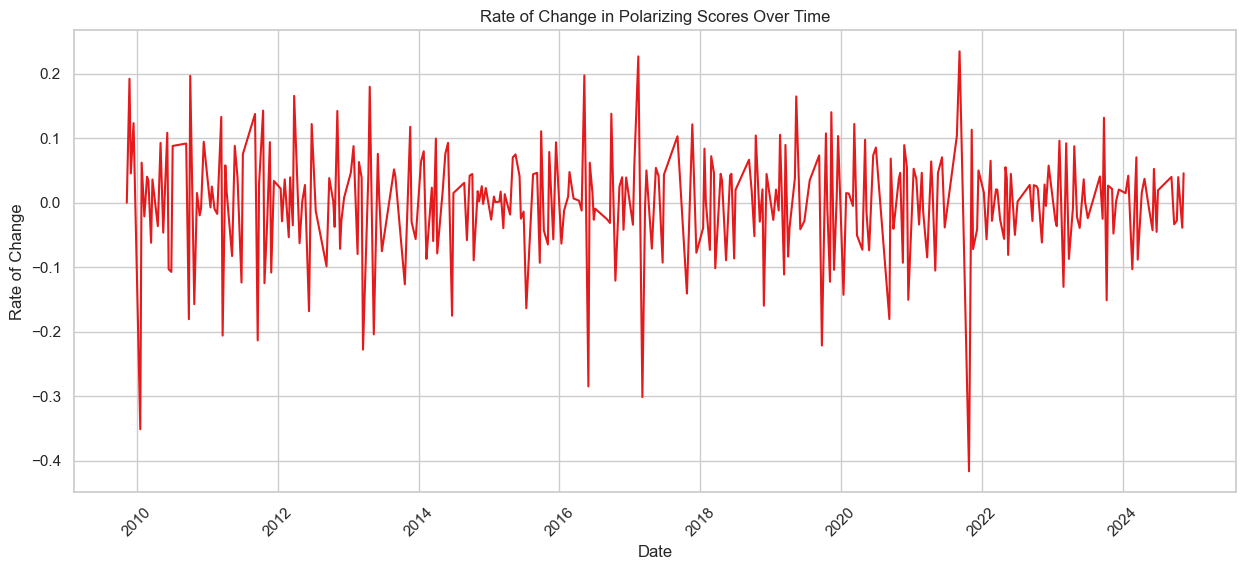

Top 10 Rises in Polarizing Scores:
     week_year  rate_of_change
250 2021-09-06        0.234848
158 2017-02-13        0.226950
142 2016-05-09        0.197427
21  2010-10-04        0.196801
2   2009-11-23        0.192308
77  2013-04-22        0.179842
55  2012-03-26        0.165745
202 2019-05-13        0.164845
43  2011-10-17        0.142847
66  2012-11-05        0.142345

Bottom 10 Falls in Polarizing Scores:
     week_year  rate_of_change
78  2013-05-13       -0.204254
32  2011-03-21       -0.206140
41  2011-09-19       -0.213603
207 2019-09-23       -0.221578
75  2013-03-18       -0.227879
143 2016-05-30       -0.284958
159 2017-03-06       -0.301587
5   2010-01-18       -0.351449
251 2021-10-25       -0.416667
0   2009-10-26             NaN


In [36]:
# Calculate the rate of change in polarizing scores
weekly_grouped['rate_of_change'] = daily_grouped['frequency'].diff()

# Sorting the DataFrame by the rate of change to find significant changes
sorted_changes = weekly_grouped.sort_values(by='rate_of_change', ascending=False)

# Select the top 5 rises and bottom 5 falls in polarizing scores
top_5_rises = sorted_changes.head(10)
bottom_5_falls = sorted_changes.tail(10)

# Plotting the rate of change
plt.figure(figsize=(15, 6))
sns.lineplot(x='week_year', y='rate_of_change', data=weekly_grouped)
plt.title('Rate of Change in Polarizing Scores Over Time')
plt.xlabel('Date')
plt.ylabel('Rate of Change')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Displaying th

print("Top 10 Rises in Polarizing Scores:")
print(top_5_rises[['week_year', 'rate_of_change']])
print("\nBottom 10 Falls in Polarizing Scores:")
print(bottom_5_falls[['week_year', 'rate_of_change']])

# 5. Development by Faction

In [27]:
# Adjusting the color map to match the faction names exactly as they appear in the dataset
color_map = {
    'CDU/CSU': 'black',
    'SPD': 'red',
    'FDP': 'yellow',
    'Bündnis 90/Die Grünen': 'green',
    'DIE LINKE.': 'pink',
    'AfD': 'blue',
    'BSW': 'purple',
    'Fraktionslos':'grey'
}

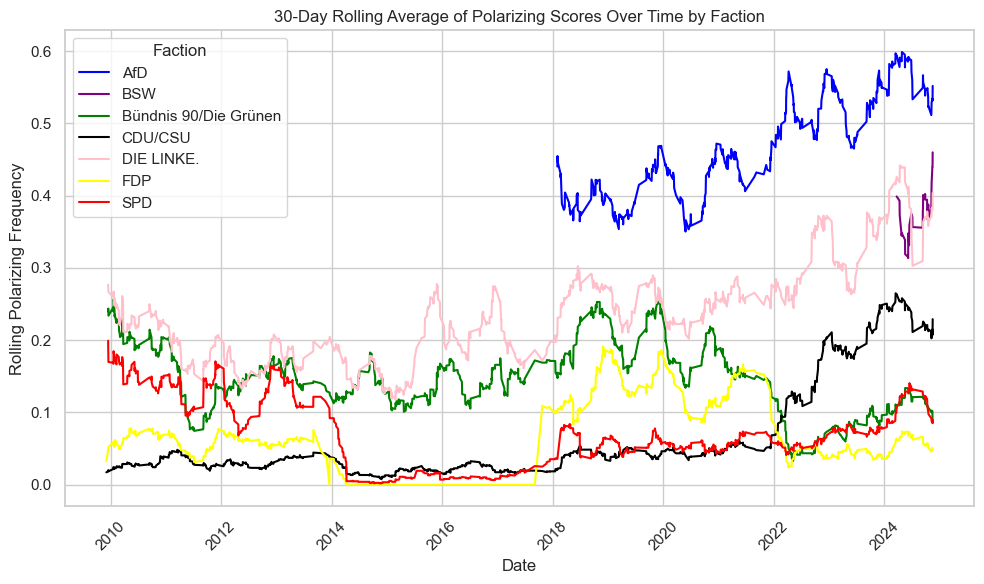

In [45]:

# Filter out 'Fraktionslos' and ensure faction names are correct in the dataframe
filtered_df = final_df[(final_df['faction'] != 'Fraktionslos')]

# Grouping by 'date' and 'faction', then calculating the polarizing frequency
faction_grouped = filtered_df.groupby(['electoral_term', 'date', 'faction']).agg({
    'polarizing': 'sum',
    'id': 'count'
}).reset_index()  # Resetting the index here
faction_grouped['frequency'] = faction_grouped['polarizing'] / faction_grouped['id']

faction_grouped = faction_grouped.sort_values(by=['faction', 'date'])

# Filter to add zero frequency data for FDP during electoral term 18
if 'FDP' not in faction_grouped[(faction_grouped['electoral_term'] == 18) & (faction_grouped['faction'] == 'FDP')].faction.values:
    # Find the date range for electoral term 18
    term_18_dates = faction_grouped[faction_grouped['electoral_term'] == 18]['date'].unique()
    # Create a DataFrame with zero values for FDP
    fdp_zeros = pd.DataFrame({
        'date': term_18_dates,
        'faction': 'FDP',
        'electoral_term': 18,
        'polarizing': 0,
        'id': 1,  # to avoid division by zero
        'frequency': 0
    })
    # Append to the original DataFrame
    faction_grouped = pd.concat([faction_grouped, fdp_zeros], ignore_index=True)

# Recalculate the rolling_frequency now including the zeroed FDP values for term 18
faction_grouped['date'] = pd.to_datetime(faction_grouped['date'])  # Ensure 'date' is a datetime object
faction_grouped['rolling_frequency_30'] = faction_grouped.groupby('faction')['frequency'].transform(lambda x: x.rolling(window=30, min_periods=10).mean())

# Plotting rolling average of polarizing frequency by faction over time with specified colors
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='rolling_frequency_30', hue='faction', palette=color_map, data=faction_grouped)
plt.title('30-Day Rolling Average of Polarizing Scores Over Time by Faction')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.legend(title='Faction')
plt.grid(True)

plt.tight_layout() 
plt.savefig('rolling_frequency_by_faction.png')
plt.show()


In [29]:
# Grouping by 'date' and 'faction', then calculating the polarizing frequency
faction_grouped_electoral_term = filtered_df.groupby(['electoral_term', 'faction']).agg({
    'polarizing': 'sum',
    'id': 'count'
}).reset_index()  # Resetting the index here
faction_grouped_electoral_term['frequency'] = faction_grouped_electoral_term['polarizing'] / faction_grouped_electoral_term['id']

faction_grouped_electoral_term = faction_grouped_electoral_term.sort_values(by=['electoral_term','faction'])
faction_grouped_electoral_term

,electoral_term,faction,polarizing,id,frequency
0,17,Bündnis 90/Die Grünen,746,5579,0.133716
1,17,CDU/CSU,391,12750,0.030667
2,17,DIE LINKE.,778,4649,0.167348
3,17,FDP,366,6649,0.055046
4,17,SPD,868,7357,0.117983
5,18,Bündnis 90/Die Grünen,664,6049,0.109770
6,18,CDU/CSU,187,10403,0.017976
7,18,DIE LINKE.,775,4486,0.172760
8,18,SPD,73,7564,0.009651
9,19,AfD,1932,4694,0.411589


In [30]:
# average frequency afd, terms 19 and 20
afd_freq = faction_grouped_electoral_term[(faction_grouped_electoral_term['faction'] == 'AfD') & (faction_grouped_electoral_term['electoral_term'].isin([19, 20]))]['frequency'].mean()
# average frequency except afd
non_afd_freq = faction_grouped_electoral_term[(faction_grouped_electoral_term['faction'] != 'AfD') & (faction_grouped_electoral_term['electoral_term'].isin([19, 20]))]['frequency'].mean()

# display the results
print("Average Afd Polarizing Frequency by Electoral Term:")
print(afd_freq)
print("\nAverage Polarizing Frequency by Electoral Term (Excluding AfD):")
print(non_afd_freq)

Average Afd Polarizing Frequency by Electoral Term:
0.46473406223982405

Average Polarizing Frequency by Electoral Term (Excluding AfD):
0.1666406079478039


In [31]:

# Fill NaN values in 'frequency' if there were any zeros in 'speech_length'
faction_grouped_electoral_term['frequency'].fillna(0, inplace=True)  # Assuming you want to treat these as zero frequency

# Continue with your grouping and calculations
avg_freq_per_term_faction = faction_grouped_electoral_term.groupby(['electoral_term', 'faction'])['frequency'].mean().reset_index()
pivot_avg_freq_faction = avg_freq_per_term_faction.pivot(index='electoral_term', columns='faction', values='frequency')
percentage_change_faction = pivot_avg_freq_faction.pct_change() * 100

# Display the result
print("Average Frequency per Electoral Term by Faction:")
print(pivot_avg_freq_faction)
print("\nPercentage Change from Previous Electoral Term:")
print(percentage_change_faction)



Average Frequency per Electoral Term by Faction:
faction              AfD       BSW  Bündnis 90/Die Grünen   CDU/CSU  \
electoral_term                                                        
17                   NaN       NaN               0.133716  0.030667   
18                   NaN       NaN               0.109770  0.017976   
19              0.411589       NaN               0.186911  0.042822   
20              0.517879  0.440217               0.079811  0.193569   

faction         DIE LINKE.       FDP       SPD  
electoral_term                                  
17                0.167348  0.055046  0.117983  
18                0.172760       NaN  0.009651  
19                0.251404  0.137033  0.059098  
20                0.317595  0.044590  0.079994  

Percentage Change from Previous Electoral Term:
faction               AfD  BSW  Bündnis 90/Die Grünen     CDU/CSU  DIE LINKE.  \
electoral_term                                                                  
17                 

Not Frequency but totals:

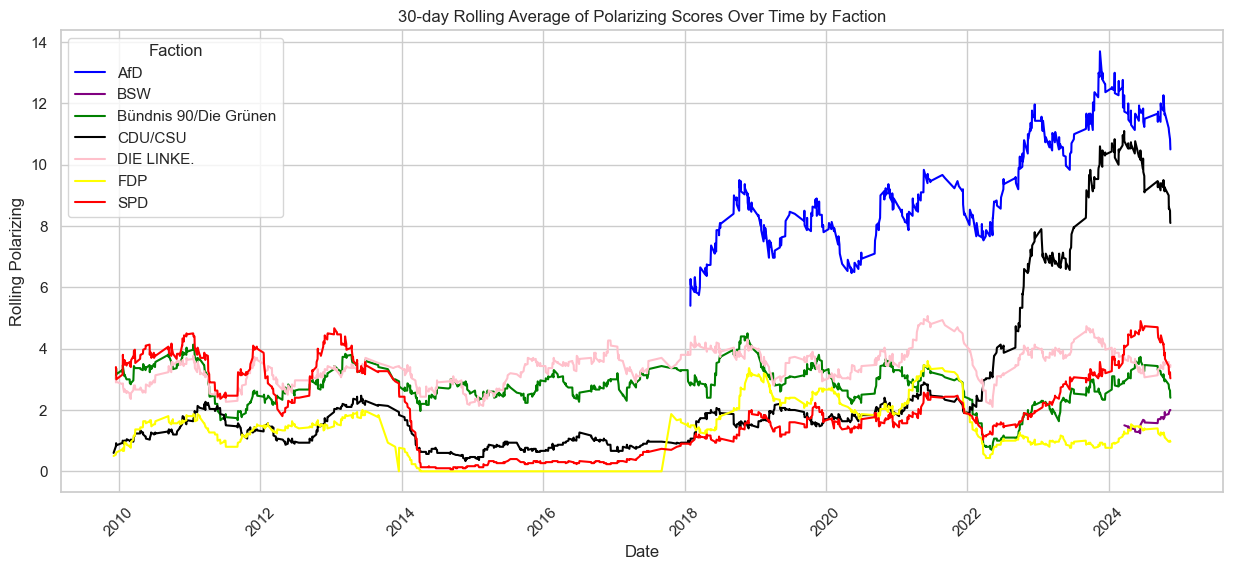

In [32]:
faction_grouped['rolling_polarizing_30'] = faction_grouped.groupby('faction')['polarizing'].transform(
    lambda x: x.rolling(window=30, min_periods=10).mean())


# Ensure 'date' is in datetime format for proper plotting
faction_grouped['date'] = pd.to_datetime(faction_grouped['date'])

# Plotting rolling average of polarizing scores by faction over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='rolling_polarizing_30', hue='faction', palette=color_map, data=faction_grouped)
plt.title('30-day Rolling Average of Polarizing Scores Over Time by Faction')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing')
plt.xticks(rotation=45)
plt.legend(title='Faction')
plt.grid(True)
plt.show()

# 6. Development by Governmennt vs. Opposition

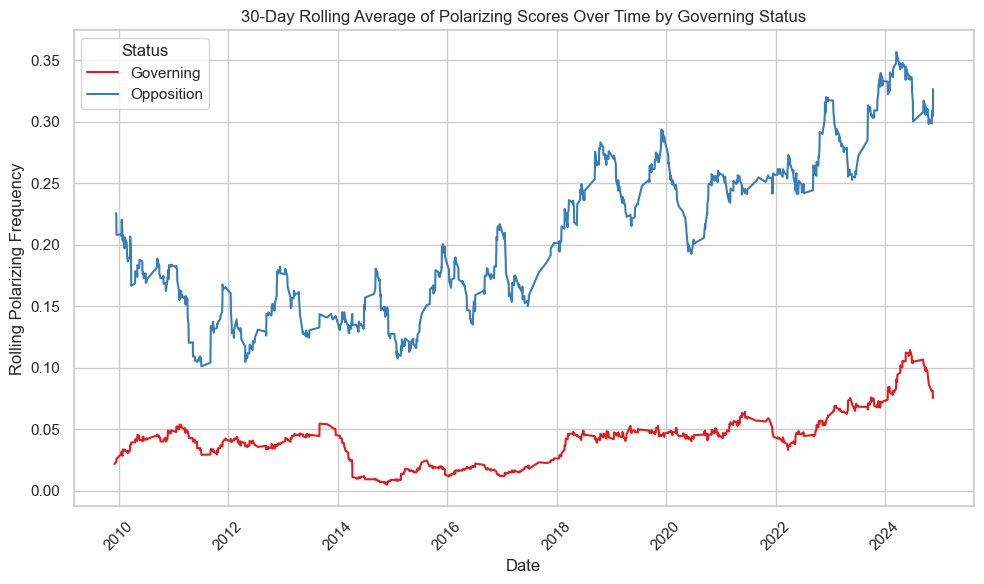

In [46]:
# Assuming 'final_df' is updated to include the 'electoral_term' column
# Define the mapping from electoral terms to governing factions
regierung_mapping = {
    17: ['CDU/CSU', 'FDP'],
    18: ['CDU/CSU', 'SPD'],
    19: ['CDU/CSU', 'SPD'],
    20: ['SPD', 'FDP', 'Bündnis 90/Die Grünen']
}

# Function to assign 'Governing' or 'Opposition' status based on the mapping
def map_governing_faction(row):
    governing_factions = regierung_mapping.get(row['electoral_term'], [])
    return 'Governing' if row['faction'] in governing_factions else 'Opposition'

# Apply the function to create a new 'status' column in final_df
final_df['status'] = final_df.apply(map_governing_faction, axis=1)

# Group by 'date' and 'status', then calculate the polarizing frequency
grouped_by_status = final_df.groupby(['electoral_term','date', 'status']).agg({
    'polarizing': 'sum',
    'id': 'count'
})
grouped_by_status['frequency'] = grouped_by_status['polarizing'] / grouped_by_status['id']

# Reset index for plotting
grouped_by_status = grouped_by_status.reset_index()
grouped_by_status['date'] = pd.to_datetime(grouped_by_status['date'])

# Applying a 30-day rolling average for smoothing, grouped by status
grouped_by_status['rolling_frequency_30'] = grouped_by_status.groupby('status')['frequency'].transform(lambda x: x.rolling(window=30, min_periods=10).mean())

# Plotting the rolling average of polarizing frequency by governing status over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='rolling_frequency_30', hue='status', data=grouped_by_status)
plt.title('30-Day Rolling Average of Polarizing Scores Over Time by Governing Status')
plt.xlabel('Date')
plt.ylabel('Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.legend(title='Status')
plt.grid(True)

plt.tight_layout()
plt.savefig('rolling_frequency_by_governing_status.png')
plt.show()

In [34]:
grouped_by_status_electoral_term = final_df.groupby(['electoral_term', 'status']).agg({
    'polarizing': 'sum',
    'id': 'count'
})
grouped_by_status_electoral_term['frequency'] = grouped_by_status_electoral_term['polarizing'] / grouped_by_status_electoral_term['id']

# Aggregate data to get the average frequency per electoral term and status
avg_freq_per_term_status_v2 = grouped_by_status_electoral_term.groupby(['electoral_term', 'status'])['frequency'].mean().reset_index()

# Pivot the data to have electoral terms as rows and status as columns
pivot_avg_freq_status_v2 = avg_freq_per_term_status_v2.pivot(index='electoral_term', columns='status', values='frequency')

# Calculate the percentage change from the previous electoral term for each status
percentage_change = pivot_avg_freq_status_v2.pct_change() * 100

# Display the result
print("Average Frequency per Electoral Term by Status:")
print(pivot_avg_freq_status_v2)
print("\nPercentage Change from Previous Electoral Term:")
print(percentage_change)


Average Frequency per Electoral Term by Status:
status          Governing  Opposition
electoral_term                       
17               0.039023    0.135616
18               0.014471    0.135252
19               0.049112    0.246805
20               0.070839    0.287277

Percentage Change from Previous Electoral Term:
status           Governing  Opposition
electoral_term                        
17                     NaN         NaN
18              -62.916455   -0.268804
19              239.379798   82.478188
20               44.240180   16.398522


Correlation

In [35]:
grouped_by_status['status_numeric'] = grouped_by_status['status'].map({'Governing': 1, 'Opposition': 0})


# Check for any NaN values that might have been introduced by the mapping
if grouped_by_status['status_numeric'].isna().any():
    print("NaN values found in 'status_numeric'. These rows will be dropped.")
    grouped_by_status.dropna(subset=['status_numeric'], inplace=True)

# Ensure 'frequency' is a float and handle any infinite values
grouped_by_status['frequency'] = pd.to_numeric(grouped_by_status['frequency'], errors='coerce')
grouped_by_status['frequency'].replace([np.inf, -np.inf], np.nan, inplace=True)
grouped_by_status.dropna(subset=['frequency'], inplace=True)

# Calculate the correlation between the numeric status and polarizing frequency
correlation = grouped_by_status['status_numeric'].corr(grouped_by_status['frequency'])

# Print the correlation coefficient
print("Correlation between governing status and polarizing frequency:", correlation)

Correlation between governing status and polarizing frequency: -0.6623301816962603


# 7. The role of elections/new governments

## 7.1 New term only

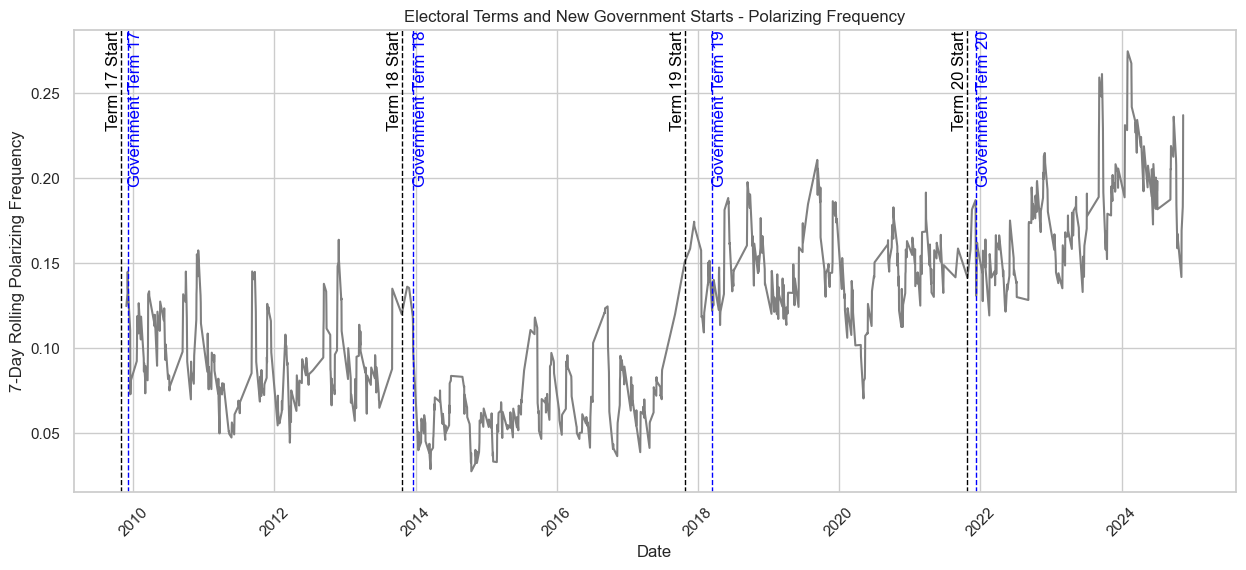

In [36]:
# Applying a 7-day rolling average for smoothing (Corrected from 30-day to 7-day as per the earlier code block)
daily_grouped['rolling_frequency_7'] = daily_grouped['frequency'].rolling(window=7, min_periods=7).mean()

# Define important dates for electoral terms and new governments
electoral_terms = {
    'Term 17 Start': '2009-10-27',
    'Term 18 Start': '2013-10-22',
    'Term 19 Start': '2017-10-24',
    'Term 20 Start': '2021-10-26'
}

new_government = {
    'Government Term 17': '2009-12-02',
    'Government Term 18': '2013-12-17',
    'Government Term 19': '2018-03-14',
    'Government Term 20': '2021-12-08'
}

# Plotting
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='date', y='rolling_frequency_7', data=daily_grouped, color='grey')

# Add vertical lines for each electoral term start
for term, start_date in electoral_terms.items():
    start_date = pd.to_datetime(start_date)
    ax.axvline(start_date, color='black', linestyle='--', lw=1)
    ax.text(start_date, ax.get_ylim()[1], term, rotation=90, ha='right', va='top', color='black', fontsize=12)

# Add vertical lines for new government starts
for term, start_date in new_government.items():
    start_date = pd.to_datetime(start_date)
    ax.axvline(start_date, color='blue', linestyle='--', lw=1)
    ax.text(start_date, ax.get_ylim()[1], term, rotation=90, ha='left', va='top', color='blue', fontsize=12)


plt.title('Electoral Terms and New Government Starts - Polarizing Frequency')
plt.xlabel('Date')
plt.ylabel('7-Day Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


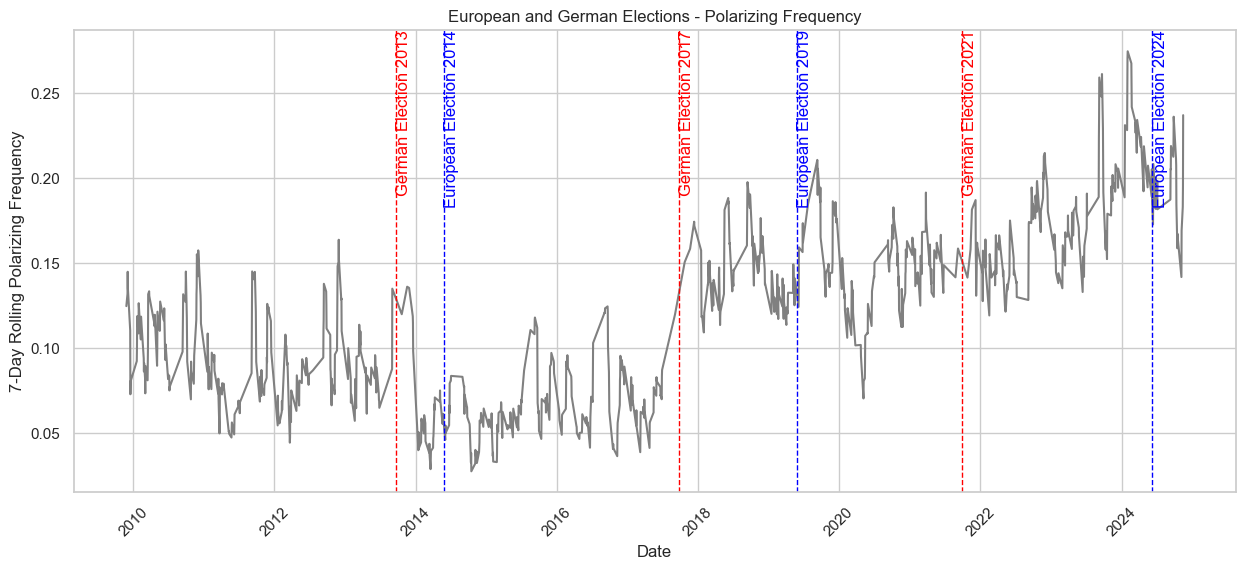

In [37]:
# European and German election dates
european_elections = {
    'European Election 2014': '2014-05-25',
    'European Election 2019': '2019-05-29',
    'European Election 2024': '2024-06-09'
}

german_elections = {
    'German Election 2013': '2013-09-22',
    'German Election 2017': '2017-09-24',
    'German Election 2021': '2021-09-26'
}

# Plotting
plt.figure(figsize=(15, 6))
ax = sns.lineplot(x='date', y='rolling_frequency_7', data=daily_grouped, color='grey')

# Add vertical lines for European elections
for election, election_date in european_elections.items():
    election_date = pd.to_datetime(election_date)
    ax.axvline(election_date, color='blue', linestyle='--', lw=1)
    ax.text(election_date, ax.get_ylim()[1], election, rotation=90, ha='left',va='top', color='blue')

# Add vertical lines for German national elections
for election, election_date in german_elections.items():
    election_date = pd.to_datetime(election_date)
    ax.axvline(election_date, color='red', linestyle='--', lw=1)
    ax.text(election_date, ax.get_ylim()[1], election, rotation=90, ha='left',va='top', color='red')

plt.title('European and German Elections - Polarizing Frequency')
plt.xlabel('Date')
plt.ylabel('7-Day Rolling Polarizing Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## 7.2 Rate of change before elections

In [38]:
daily_grouped = final_df.groupby(['electoral_term','date']).agg({'polarizing': 'sum', 'id': 'count'})
daily_grouped['frequency'] = daily_grouped['polarizing'] / daily_grouped['id']
daily_grouped = daily_grouped.reset_index()


In [39]:


# Provided election dates and important term starts
election_dates = pd.to_datetime(['2009-09-27', '2013-09-22', '2017-09-24', '2021-09-26'])
term_starts = {
    17: '2009-10-27',
    18: '2013-10-22',
    19: '2017-10-24',
    20: '2021-10-26'
}


# Initialize an empty DataFrame for the results
results = []

# Function to compute averages around a date
def compute_averages_around_date(df, center_date, months_pre=3, months_post=3):
    pre_date_start = center_date - pd.DateOffset(months=months_pre)
    post_date_end = center_date + pd.DateOffset(months=months_post)
    pre_data = df[(df['date'] >= pre_date_start) & (df['date'] < center_date)]
    post_data = df[(df['date'] > center_date) & (df['date'] <= post_date_end)]
    return pre_data['frequency'].mean(), post_data['frequency'].mean()

# Analyze around each election
for date in election_dates:
    pre_avg, post_avg = compute_averages_around_date(daily_grouped, date)
    results.append({
        'Event': f'Election {date.year}',
        'Pre-Event Average Frequency': pre_avg,
        'Post-Event Average Frequency': post_avg
    })

# Calculate overall and transitional period averages
for term, start_date in term_starts.items():
    term_data = daily_grouped[daily_grouped['electoral_term'] == term]
    overall_avg = term_data['frequency'].mean()  # Overall term average
    
    # Identify the relevant election date
    if term > 17:  # Since Term 17 starts after the 2009 election
        election_date = pd.to_datetime(term_starts[term])
        # Transitional period from election to term start
        transition_end = pd.to_datetime(term_starts[term]) + pd.DateOffset(months=3)
        transition_data = daily_grouped[(daily_grouped['date'] > election_date) & (daily_grouped['date'] <= transition_end)]
        transition_avg = transition_data['frequency'].mean()
        
        results.append({
            'Term': term,
            'Overall Average Frequency': overall_avg,
            'Transition Average Frequency': transition_avg,
            'Percentage Change': ((transition_avg - overall_avg) / overall_avg) * 100 if overall_avg else None
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df

,Event,Pre-Event Average Frequency,Post-Event Average Frequency,Term,Overall Average Frequency,Transition Average Frequency,Percentage Change
0,Election 2009,NaN,0.104867,NaN,NaN,NaN,NaN
1,Election 2013,0.139882,0.045058,NaN,NaN,NaN,NaN
2,Election 2017,0.152501,0.155868,NaN,NaN,NaN,NaN
3,Election 2021,0.174474,0.160406,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,18.0,0.065672,0.049926,-23.975923
5,NaN,NaN,NaN,19.0,0.145737,0.119059,-18.305546
6,NaN,NaN,NaN,20.0,0.182189,0.149027,-18.202256


## 7.3 Months post and prior elections

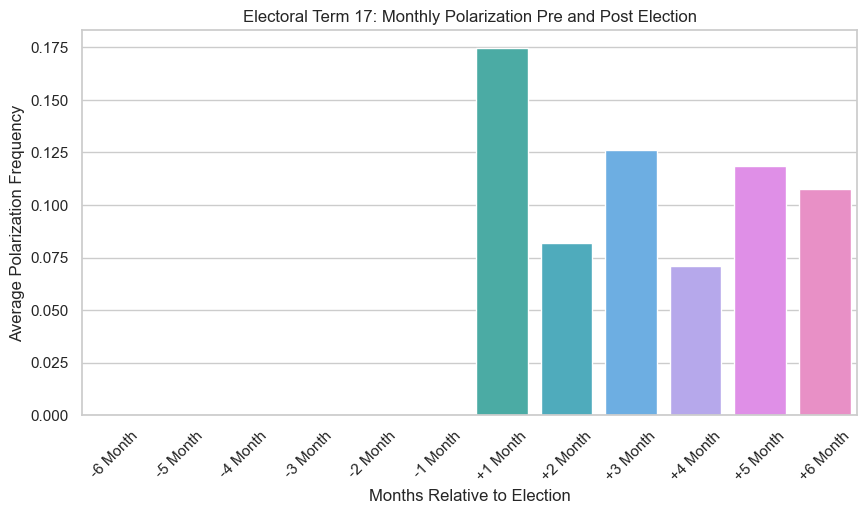

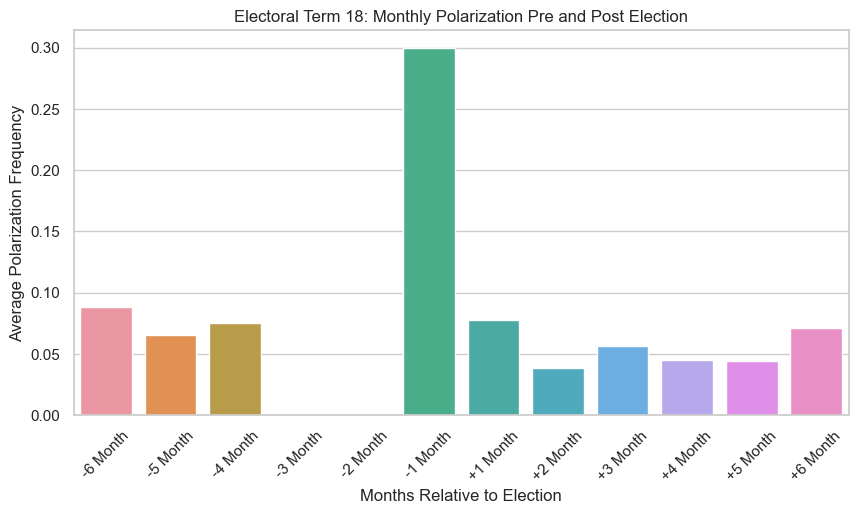

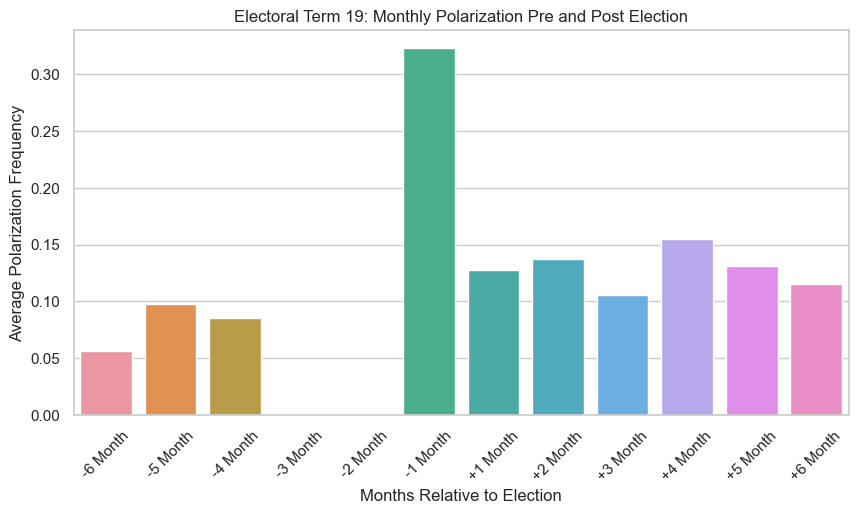

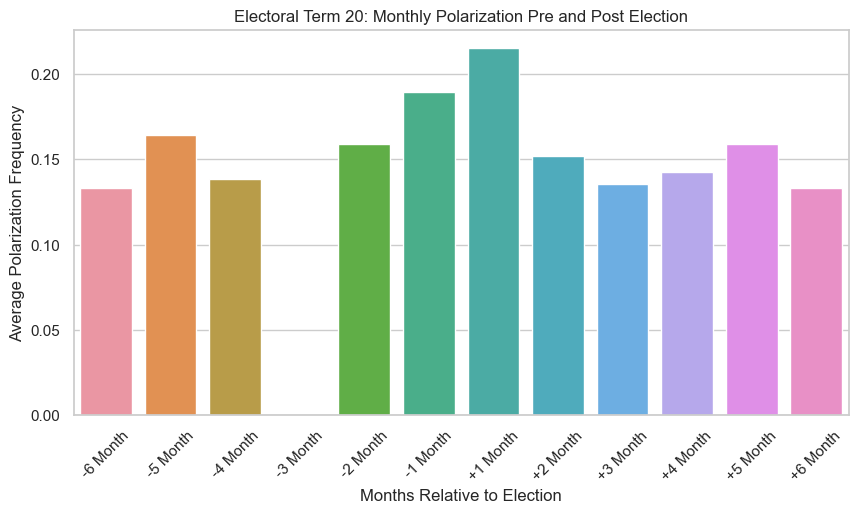

In [40]:
# Election dates for each electoral term
election_dates = {
    17: '2009-09-27',
    18: '2013-09-22',
    19: '2017-09-24',
    20: '2021-09-26'
}

# Convert dates from string to datetime
for term, date in election_dates.items():
    election_dates[term] = pd.to_datetime(date)

# Process each term separately
for term, election_date in election_dates.items():
    # Generate date ranges for 6 months before and after the election
    pre_dates = pd.date_range(end=election_date, periods=6, freq='M', closed='left')
    post_dates = pd.date_range(start=election_date, periods=7, freq='M')[1:]  # Exclude the election month start

    # Collect data for each range
    monthly_averages = []
    labels = [f'-{6-i} Month' for i in range(6)] + [f'+{i+1} Month' for i in range(6)]

    for date in pre_dates:
        month_data = daily_grouped[(daily_grouped['date'] >= date) & (daily_grouped['date'] < date + pd.DateOffset(months=1))]
        monthly_averages.append(month_data['frequency'].mean())
    
    for date in post_dates:
        month_data = daily_grouped[(daily_grouped['date'] >= date) & (daily_grouped['date'] < date + pd.DateOffset(months=1))]
        monthly_averages.append(month_data['frequency'].mean())

    # Plotting
    plt.figure(figsize=(10, 5))
    sns.barplot(x=labels, y=monthly_averages)
    plt.title(f'Electoral Term {term}: Monthly Polarization Pre and Post Election')
    plt.xlabel('Months Relative to Election')
    plt.ylabel('Average Polarization Frequency')
    plt.xticks(rotation=45)
    plt.show()

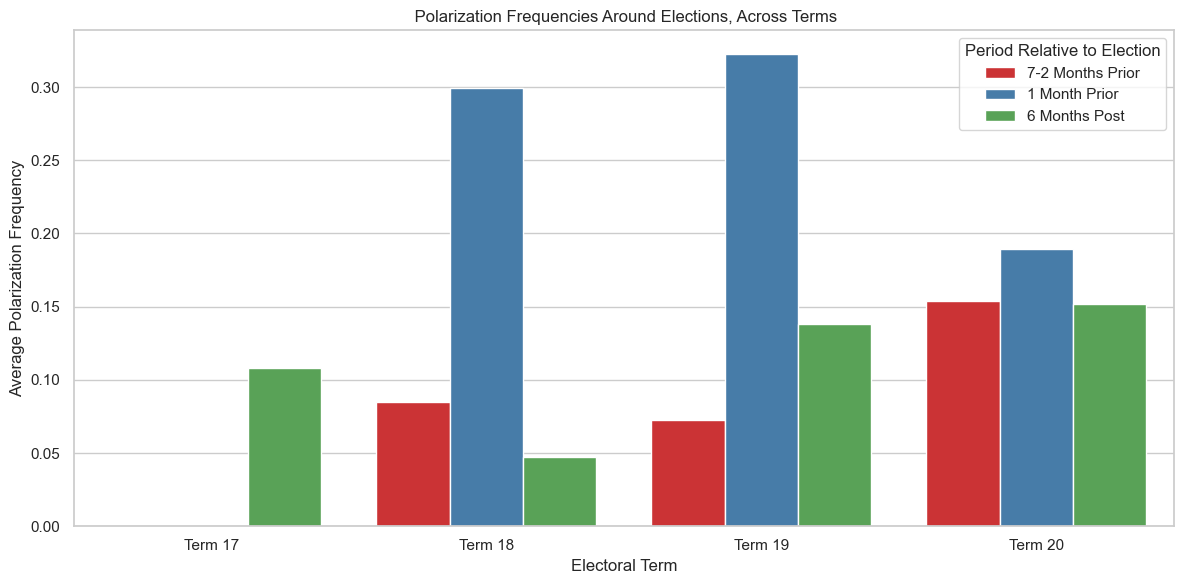

In [41]:
election_dates = {
    17: '2009-09-27',
    18: '2013-09-22',
    19: '2017-09-24',
    20: '2021-09-26'
}

# DataFrame to store the results
results_df = pd.DataFrame()

sns.set_style('whitegrid')
sns.set_palette('Set1')

# Process each electoral term
for term, date in election_dates.items():
    election_date = pd.to_datetime(date)
    periods = {
        '7-2 Months Prior': (election_date - pd.DateOffset(months=7), election_date - pd.DateOffset(months=2)),
        '1 Month Prior': (election_date - pd.DateOffset(months=1), election_date),
        '6 Months Post': (election_date, election_date + pd.DateOffset(months=6))
    }

    # Calculate the average frequency for each period
    for label, (start, end) in periods.items():
        month_data = daily_grouped[(daily_grouped['date'] >= start) & (daily_grouped['date'] < end)]
        avg_frequency = month_data['frequency'].mean()

        # Append to results DataFrame
        results_df = results_df.append({
            'Term': f'Term {term}',
            'Period': label,
            'Average Frequency': avg_frequency
        }, ignore_index=True)

# Plotting all results in one plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Term', y='Average Frequency', hue='Period', data=results_df)
plt.title(' Polarization Frequencies Around Elections, Across Terms')
plt.ylabel('Average Polarization Frequency')
plt.xlabel('Electoral Term')
plt.legend(title='Period Relative to Election')

plt.tight_layout()
plt.savefig('polarization_frequencies_around_elections.png')
plt.show()

In [42]:
pre_election_2_7_months = results_df[results_df['Period'] == '7-2 Months Prior']
month_before_election = results_df[results_df['Period'] == '1 Month Prior']

# Initialize a list to store increase data
increases = []

# Iterate over terms to calculate increases
terms = results_df['Term'].unique()
for term in terms:
    pre_avg = pre_election_2_7_months[pre_election_2_7_months['Term'] == term]['Average Frequency'].values[0]
    month_before_avg = month_before_election[month_before_election['Term'] == term]['Average Frequency'].values[0]
    
    # Calculate percentage increase
    if pre_avg != 0:  # To avoid division by zero
        increase = ((month_before_avg - pre_avg) / pre_avg) * 100
    else:
        increase = None  # In case pre_avg is zero, handle it as no data available

    # Append to the list
    increases.append({
        'Term': term,
        'Pre-Election 7-2 Months Avg': pre_avg,
        'Pre-Election 1 Month Avg': month_before_avg,
        'Percentage Increase': increase
    })

# Convert the list to a DataFrame
increase_df = pd.DataFrame(increases)
increase_df

,Term,Pre-Election 7-2 Months Avg,Pre-Election 1 Month Avg,Percentage Increase
0,Term 17,NaN,NaN,NaN
1,Term 18,0.084717,0.299242,253.226187
2,Term 19,0.072799,0.322581,343.110567
3,Term 20,0.153978,0.189655,23.170012


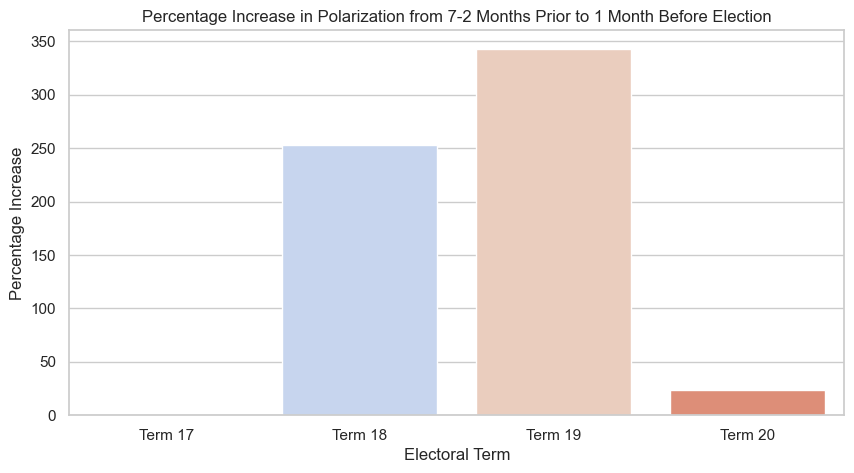

In [43]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Term', y='Percentage Increase', data=increase_df, palette='coolwarm')
plt.title('Percentage Increase in Polarization from 7-2 Months Prior to 1 Month Before Election')
plt.ylabel('Percentage Increase')
plt.xlabel('Electoral Term')
plt.show()